<a href="https://colab.research.google.com/github/claudio1975/Climate_Risk_Modelling_with_LLMs/blob/main/multi_step/Flood_pred_damage_property_work_multi_step_aug_v_4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [ ]:
! pip install optuna &> /dev/null

In [ ]:
# utils packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import datetime
import scipy
import scipy.stats as stats
import statsmodels
import sklearn
import lightgbm
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from math import radians, sin, cos, sqrt, atan2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import randint
import optuna


# packages for prediction and other utils functions
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

# to evaluate models
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import make_scorer

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
np.__version__

'1.25.2'

In [ ]:
pd.__version__

'2.0.3'

In [ ]:
matplotlib.__version__

'3.7.1'

In [ ]:
sns.__version__

'0.13.1'

In [ ]:
scipy.__version__

'1.11.4'

In [ ]:
statsmodels.__version__

'0.14.2'

In [ ]:
sklearn.__version__

'1.2.2'

In [ ]:
optuna.__version__

'3.6.1'

In [ ]:
lightgbm.__version__

'4.1.0'

### Upload data set

In [ ]:
df=pd.read_csv('./flood_dataset_fe4.csv',index_col=0)

### Handling Date Time format

In [ ]:
# Trasform BEGIN_DATE_TIME and END_DATE_TIME in datetime format
df["BEGIN_DATE_TIME"] = pd.to_datetime(df["BEGIN_DATE_TIME"], format="%d-%b-%y %H:%M:%S")
df["END_DATE_TIME"] = pd.to_datetime(df["END_DATE_TIME"], format="%d-%b-%y %H:%M:%S")

In [ ]:
# Cast datetime variable in datetime format.
df.index = pd.to_datetime(df.BEGIN_DATE_TIME)
df.index.names = ['Date']
# Sort DataFrame by date column in descending order
df.sort_values(by='Date', ascending = True, inplace = True)
# Sanity check: data span.
df.index.min(), df.index.max()

(Timestamp('2006-10-02 14:00:00'), Timestamp('2022-12-31 23:00:00'))

### Have a brief look of the data set

In [ ]:
df.shape

(38398, 53)

In [ ]:
df.columns

Index(['EVENT_ID', 'BEGIN_DATE_TIME', 'END_DATE_TIME', 'STATE', 'STATE_FIPS',
       'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO', 'CZ_TIMEZONE',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'FLOOD_CAUSE', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION',
       'END_RANGE', 'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON',
       'END_LAT', 'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
       'predicted_sentiment_gpt', 'embed_episod_gpt0', 'embed_episod_gpt1',
       'embed_episod_gpt2', 'embed_episod_gpt3', 'embed_episod_gpt4',
       'embed_episod_gpt5', 'embed_episod_gpt6', 'embed_episod_gpt7',
       'embed_episod_gpt8', 'embed_episod_gpt9', 'embed_event_gpt0',
       'embed_event_gpt1', 'embed_event_gpt2', 'embed_event_gpt3',
       'embed_event_gpt4', 'embed_event_gpt5', 'embed_event_gpt6',
       'embed_event_gpt7', 'embed_event_gpt8', 'embed_event_gpt9',
       

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38398 entries, 2006-10-02 14:00:00 to 2022-12-31 23:00:00
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   EVENT_ID                 38398 non-null  int64         
 1   BEGIN_DATE_TIME          38398 non-null  datetime64[ns]
 2   END_DATE_TIME            38398 non-null  datetime64[ns]
 3   STATE                    38398 non-null  object        
 4   STATE_FIPS               38398 non-null  float64       
 5   EVENT_TYPE               38398 non-null  object        
 6   CZ_TYPE                  38398 non-null  object        
 7   CZ_FIPS                  38398 non-null  int64         
 8   CZ_NAME                  38398 non-null  object        
 9   WFO                      38398 non-null  object        
 10  CZ_TIMEZONE              38398 non-null  object        
 11  INJURIES_DIRECT          38398 non-null  int64         
 1

In [ ]:
num_cols = [var for var in df.columns if df[var].dtype in ['int64','float64']]
num = df[num_cols]
num.columns

Index(['EVENT_ID', 'STATE_FIPS', 'CZ_FIPS', 'INJURIES_DIRECT',
       'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'BEGIN_RANGE', 'END_RANGE',
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'embed_episod_gpt0',
       'embed_episod_gpt1', 'embed_episod_gpt2', 'embed_episod_gpt3',
       'embed_episod_gpt4', 'embed_episod_gpt5', 'embed_episod_gpt6',
       'embed_episod_gpt7', 'embed_episod_gpt8', 'embed_episod_gpt9',
       'embed_event_gpt0', 'embed_event_gpt1', 'embed_event_gpt2',
       'embed_event_gpt3', 'embed_event_gpt4', 'embed_event_gpt5',
       'embed_event_gpt6', 'embed_event_gpt7', 'embed_event_gpt8',
       'embed_event_gpt9'],
      dtype='object')

In [ ]:
obj_cols = [var for var in df.columns if df[var].dtype in ['object']]
cat = df[obj_cols]
cat.columns

Index(['STATE', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_NAME', 'WFO', 'CZ_TIMEZONE',
       'SOURCE', 'FLOOD_CAUSE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION',
       'END_AZIMUTH', 'END_LOCATION', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
       'predicted_sentiment_gpt', 'predicted_risk_gpt'],
      dtype='object')

### Build features

In [ ]:
# Created year, month, day, time begin/end feature
df_1 = df.copy()
df_1['YEAR_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).year
df_1['MONTH_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).month
df_1['DAY_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).day
df_1['HOUR_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).hour
df_1['YEAR_BEGIN']= df_1["YEAR_BEGIN"].astype("int64")
df_1['MONTH_BEGIN']= df_1["MONTH_BEGIN"].astype("int64")
df_1['DAY_BEGIN']= df_1["DAY_BEGIN"].astype("int64")
df_1['HOUR_BEGIN']= df_1["HOUR_BEGIN"].astype("int64")
df_1['YEAR_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).year
df_1['MONTH_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).month
df_1['DAY_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).day
df_1['HOUR_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).hour
df_1['YEAR_END']= df_1["YEAR_END"].astype("int64")
df_1['MONTH_END']= df_1["MONTH_END"].astype("int64")
df_1['DAY_END']= df_1["DAY_END"].astype("int64")
df_1['HOUR_END']= df_1["HOUR_END"].astype("int64")

In [ ]:
# Calculate the difference between dates and convert it to days and hours
df_1['DAY_DURATION'] = (df_1['END_DATE_TIME'] - df_1['BEGIN_DATE_TIME']).dt.days
df_1['HOUR_DURATION'] = (df_1['END_DATE_TIME'] - df_1['BEGIN_DATE_TIME']).dt.total_seconds() / 3600

In [ ]:
# Merge Origin and Destination to have a look at the round event
df_1['LOCATION_ORIGIN_DESTINATION'] = df_1['BEGIN_LOCATION']+'-'+df_1['END_LOCATION']
df_1['BEGIN_END_AZIMUTH'] = df_1['BEGIN_AZIMUTH']+'-'+df_1['END_AZIMUTH']

In [ ]:
# new target features
df_1['WHOLE_INJURIES'] = df_1['INJURIES_INDIRECT'] + df_1['INJURIES_DIRECT']
df_1['WHOLE_DEATHS'] = df_1['DEATHS_INDIRECT'] + df_1['DEATHS_DIRECT']
df_1['WHOLE_DAMAGE'] = df_1['DAMAGE_CROPS'] + df_1['DAMAGE_PROPERTY']
df_1['NBCLAIMS_DIRECT'] = df_1['INJURIES_DIRECT'] + df_1['DEATHS_DIRECT']
df_1['A_DAMAGE_PROPERTY'] = df_1.apply(lambda row: row['DAMAGE_PROPERTY'] / row['NBCLAIMS_DIRECT'] if row['NBCLAIMS_DIRECT'] > 0 else 0, axis=1)


In [ ]:
# Distance of the event
def haversine_distance(row):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = radians(row['BEGIN_LAT']), radians(row['BEGIN_LON'])
    lat2, lon2 = radians(row['END_LAT']), radians(row['END_LON'])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    radius_of_earth = 6371  # Earth's radius in kilometers
    distance = radius_of_earth * c

    return distance

In [ ]:
# Distance
df_1['DISTANCE'] = df_1.apply(haversine_distance, axis=1)
df_1['DISTANCE_RANGE']=df_1['END_RANGE']-df_1['BEGIN_RANGE']

In [ ]:
# Drop old variables replaced by new variables
df_2=df_1.copy()
df_2 = df_2.drop(['BEGIN_LOCATION','END_LOCATION','BEGIN_AZIMUTH','END_AZIMUTH',
                  'INJURIES_INDIRECT','DEATHS_INDIRECT','DAMAGE_CROPS',
                  'END_RANGE','BEGIN_RANGE','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON',
                  'DEATHS_DIRECT','INJURIES_DIRECT','DAMAGE_PROPERTY'], axis=1)

### Encoding

In [ ]:
df_encod=df_2.copy()

In [ ]:
# encod_predicted_sentiment_gpt
encod_sentiment = {'negative':'0','positive':'1','neutral':'2'}
df_encod['predicted_sentiment_gpt'] = df_encod['predicted_sentiment_gpt'].map(encod_sentiment)
df_encod['predicted_sentiment_gpt']= df_encod['predicted_sentiment_gpt'].astype(int)
# encod_predicted_risk_gpt
encod_risk = {'high risk':'0','medium risk':'1','low risk':'2'}
df_encod['predicted_risk_gpt'] = df_encod['predicted_risk_gpt'].map(encod_risk)
df_encod['predicted_risk_gpt']= df_encod['predicted_risk_gpt'].astype(int)


In [ ]:
# grouping_STATE
# '0' -> 'OTHERS'
state_group = {'LOUSIANA':'1','TENNESSEE':'2','FLORIDA':'3','IOWA':'4','VERMONT':'5','MISSISSIPPI':'6','TEXAS':'7','NEW JERSEY':'8'}
df_encod['STATE'] = df_encod['STATE'].map(state_group)
df_encod['STATE'].fillna('0', inplace=True)
df_encod['STATE']= df_encod['STATE'].astype(int)


In [ ]:
# grouping_CZ_NAME
# '0' -> 'OTHERS'
state_group = {'SHELBY':'1','EAST BATON ROUGE':'2','DAVIDSON':'3','LIVINGSTON':'4','ASCENSION':'5','TUNICA':'6','LINN':'7','LAFAYETTE':'8'}
df_encod['CZ_NAME'] = df_encod['CZ_NAME'].map(state_group)
df_encod['CZ_NAME'].fillna('0', inplace=True)
df_encod['CZ_NAME']= df_encod['CZ_NAME'].astype(int)


In [ ]:
# grouping_WFO
# '0' -> 'OTHERS'
state_group = {'LIX':'1','MEG':'2','LCH':'3','OHX':'4','MLB':'5','DVN':'6','BTV':'7','PHI':'8'}
df_encod['WFO'] = df_encod['WFO'].map(state_group)
df_encod['WFO'].fillna('0', inplace=True)
df_encod['WFO']= df_encod['WFO'].astype(int)


In [ ]:
# grouping_CZ_TIMEZONE
# '0' -> 'OTHERS'
state_group = {'CST-6':'1','PST-8':'2','MST-7':'3','EST-5':'4'}
df_encod['CZ_TIMEZONE'] = df_encod['CZ_TIMEZONE'].map(state_group)
df_encod['CZ_TIMEZONE'].fillna('0', inplace=True)
df_encod['CZ_TIMEZONE']= df_encod['CZ_TIMEZONE'].astype(int)

In [ ]:
# grouping_SOURCE
# '0' -> 'OTHERS'
state_group = {'Law Enforcement':'1','Newspaper':'2','NWS Storm Survey':'3','Emergency Manager':'4','Other Federal Agency':'5','Official NWS Observations':'6','River/Stream Gage':'7','Trained Spotter':'8'}
df_encod['SOURCE'] = df_encod['SOURCE'].map(state_group)
df_encod['SOURCE'].fillna('0', inplace=True)
df_encod['SOURCE']= df_encod['SOURCE'].astype(int)

In [ ]:
# grouping_FLOOD_CAUSE
# '0' -> 'OTHERS'
state_group = {'Heavy Rain':'1','Heavy Rain/Snow Melt':'2','Heavy Rain/Tropical System':'3','Dam/Levee Break':'4'}
df_encod['FLOOD_CAUSE'] = df_encod['FLOOD_CAUSE'].map(state_group)
df_encod['FLOOD_CAUSE'].fillna('0', inplace=True)
df_encod['FLOOD_CAUSE']= df_encod['FLOOD_CAUSE'].astype(int)

In [ ]:
# grouping_BEGIN_END_AZIMUTH
# '0' -> 'OTHERS'
state_group = {'W-WSW':'1','N-N':'2','NNW-ENE':'3','SW-N':'4','N-SSE':'5','SW-SSW':'6','W-SW':'7'}
df_encod['BEGIN_END_AZIMUTH'] = df_encod['BEGIN_END_AZIMUTH'].map(state_group)
df_encod['BEGIN_END_AZIMUTH'].fillna('0', inplace=True)
df_encod['BEGIN_END_AZIMUTH']= df_encod['BEGIN_END_AZIMUTH'].astype(int)

In [ ]:
# grouping_LOCATION_ORIGIN_DESTINATION
# '0' -> 'OTHERS'
state_group = {'DARWIN-DARWIN':'1','PLAINS-WOODLAWN':'2','RURAL HILL-HERMITAGE':'3','WEISS-ALBANY':'4','HOBART-MARCHAND':'5','JEFFRIES-HAMLIN':'6'}
df_encod['LOCATION_ORIGIN_DESTINATION'] = df_encod['LOCATION_ORIGIN_DESTINATION'].map(state_group)
df_encod['LOCATION_ORIGIN_DESTINATION'].fillna('0', inplace=True)
df_encod['LOCATION_ORIGIN_DESTINATION']= df_encod['LOCATION_ORIGIN_DESTINATION'].astype(int)

### Remove Outliers

In [ ]:
df_3=df_encod.copy()

#### Fine-Tuning Isolation Forest

In [ ]:
# Create a custom scorer object
#gamma_scorer = make_scorer(mean_gamma_deviance, greater_is_better=False)

#param_grid = {
#    "contamination": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
#}

#iso_forest = IsolationForest(random_state=0)
#iso_forest_model = GridSearchCV(iso_forest, param_grid, cv=5, scoring=gamma_scorer)
#iso_forest_model.fit(df_3[['NBCLAIMS_DIRECT','A_DAMAGE_PROPERTY',
#                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE']])

#print("Best parameters:", iso_forest_model.best_params_)

#### Fit the model

In [ ]:
def is_outlier(x):
    return 'yes' if x == -1 else 'no'

model = IsolationForest(contamination=0.01, random_state=0)
predictions = model.fit_predict(df_3[['NBCLAIMS_DIRECT','A_DAMAGE_PROPERTY',
                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE']])
outliers = np.vectorize(is_outlier)(predictions)
outliers_series = pd.DataFrame(outliers, columns=['outliers'], index=df_3.index)
df_3_ = pd.concat([df_3, outliers_series], axis=1)

In [ ]:
df_3_.query('outliers=="yes"').shape

(360, 57)

In [ ]:
df_4 = df_3_.query('outliers=="no"')
# remove dditional outliers from large amounts
df_4 = df_4[df_4['A_DAMAGE_PROPERTY'] <=20000]
df_4.shape

(38036, 57)

In [ ]:
# drop not useful features and targets not used
df_5=df_4.drop(['EVENT_ID','BEGIN_DATE_TIME','END_DATE_TIME','EPISODE_NARRATIVE',
                     'EVENT_NARRATIVE','EVENT_TYPE','CZ_TYPE','outliers',
                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE'], axis=1)


In [ ]:
target = df_5[['A_DAMAGE_PROPERTY']]
X_all = df_5.drop(['A_DAMAGE_PROPERTY'], axis=1)
X_all.shape

(38036, 45)

### Zero Variance Predictors

In [ ]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) ==0]
to_drop

['LOCATION_ORIGIN_DESTINATION']

In [ ]:
# Drop features
X_all_v = X_all.drop(X_all[to_drop], axis=1)

### Normality Test

In [ ]:
# normality test
stat, p = shapiro(X_all_v)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
  print('Sample looks Gaussian (fail to reject H0)')
else:
  print('Sample does not look Gaussian (reject H0)')

Statistics=0.230, p=0.000
Sample does not look Gaussian (reject H0)


### Correlated Predictors

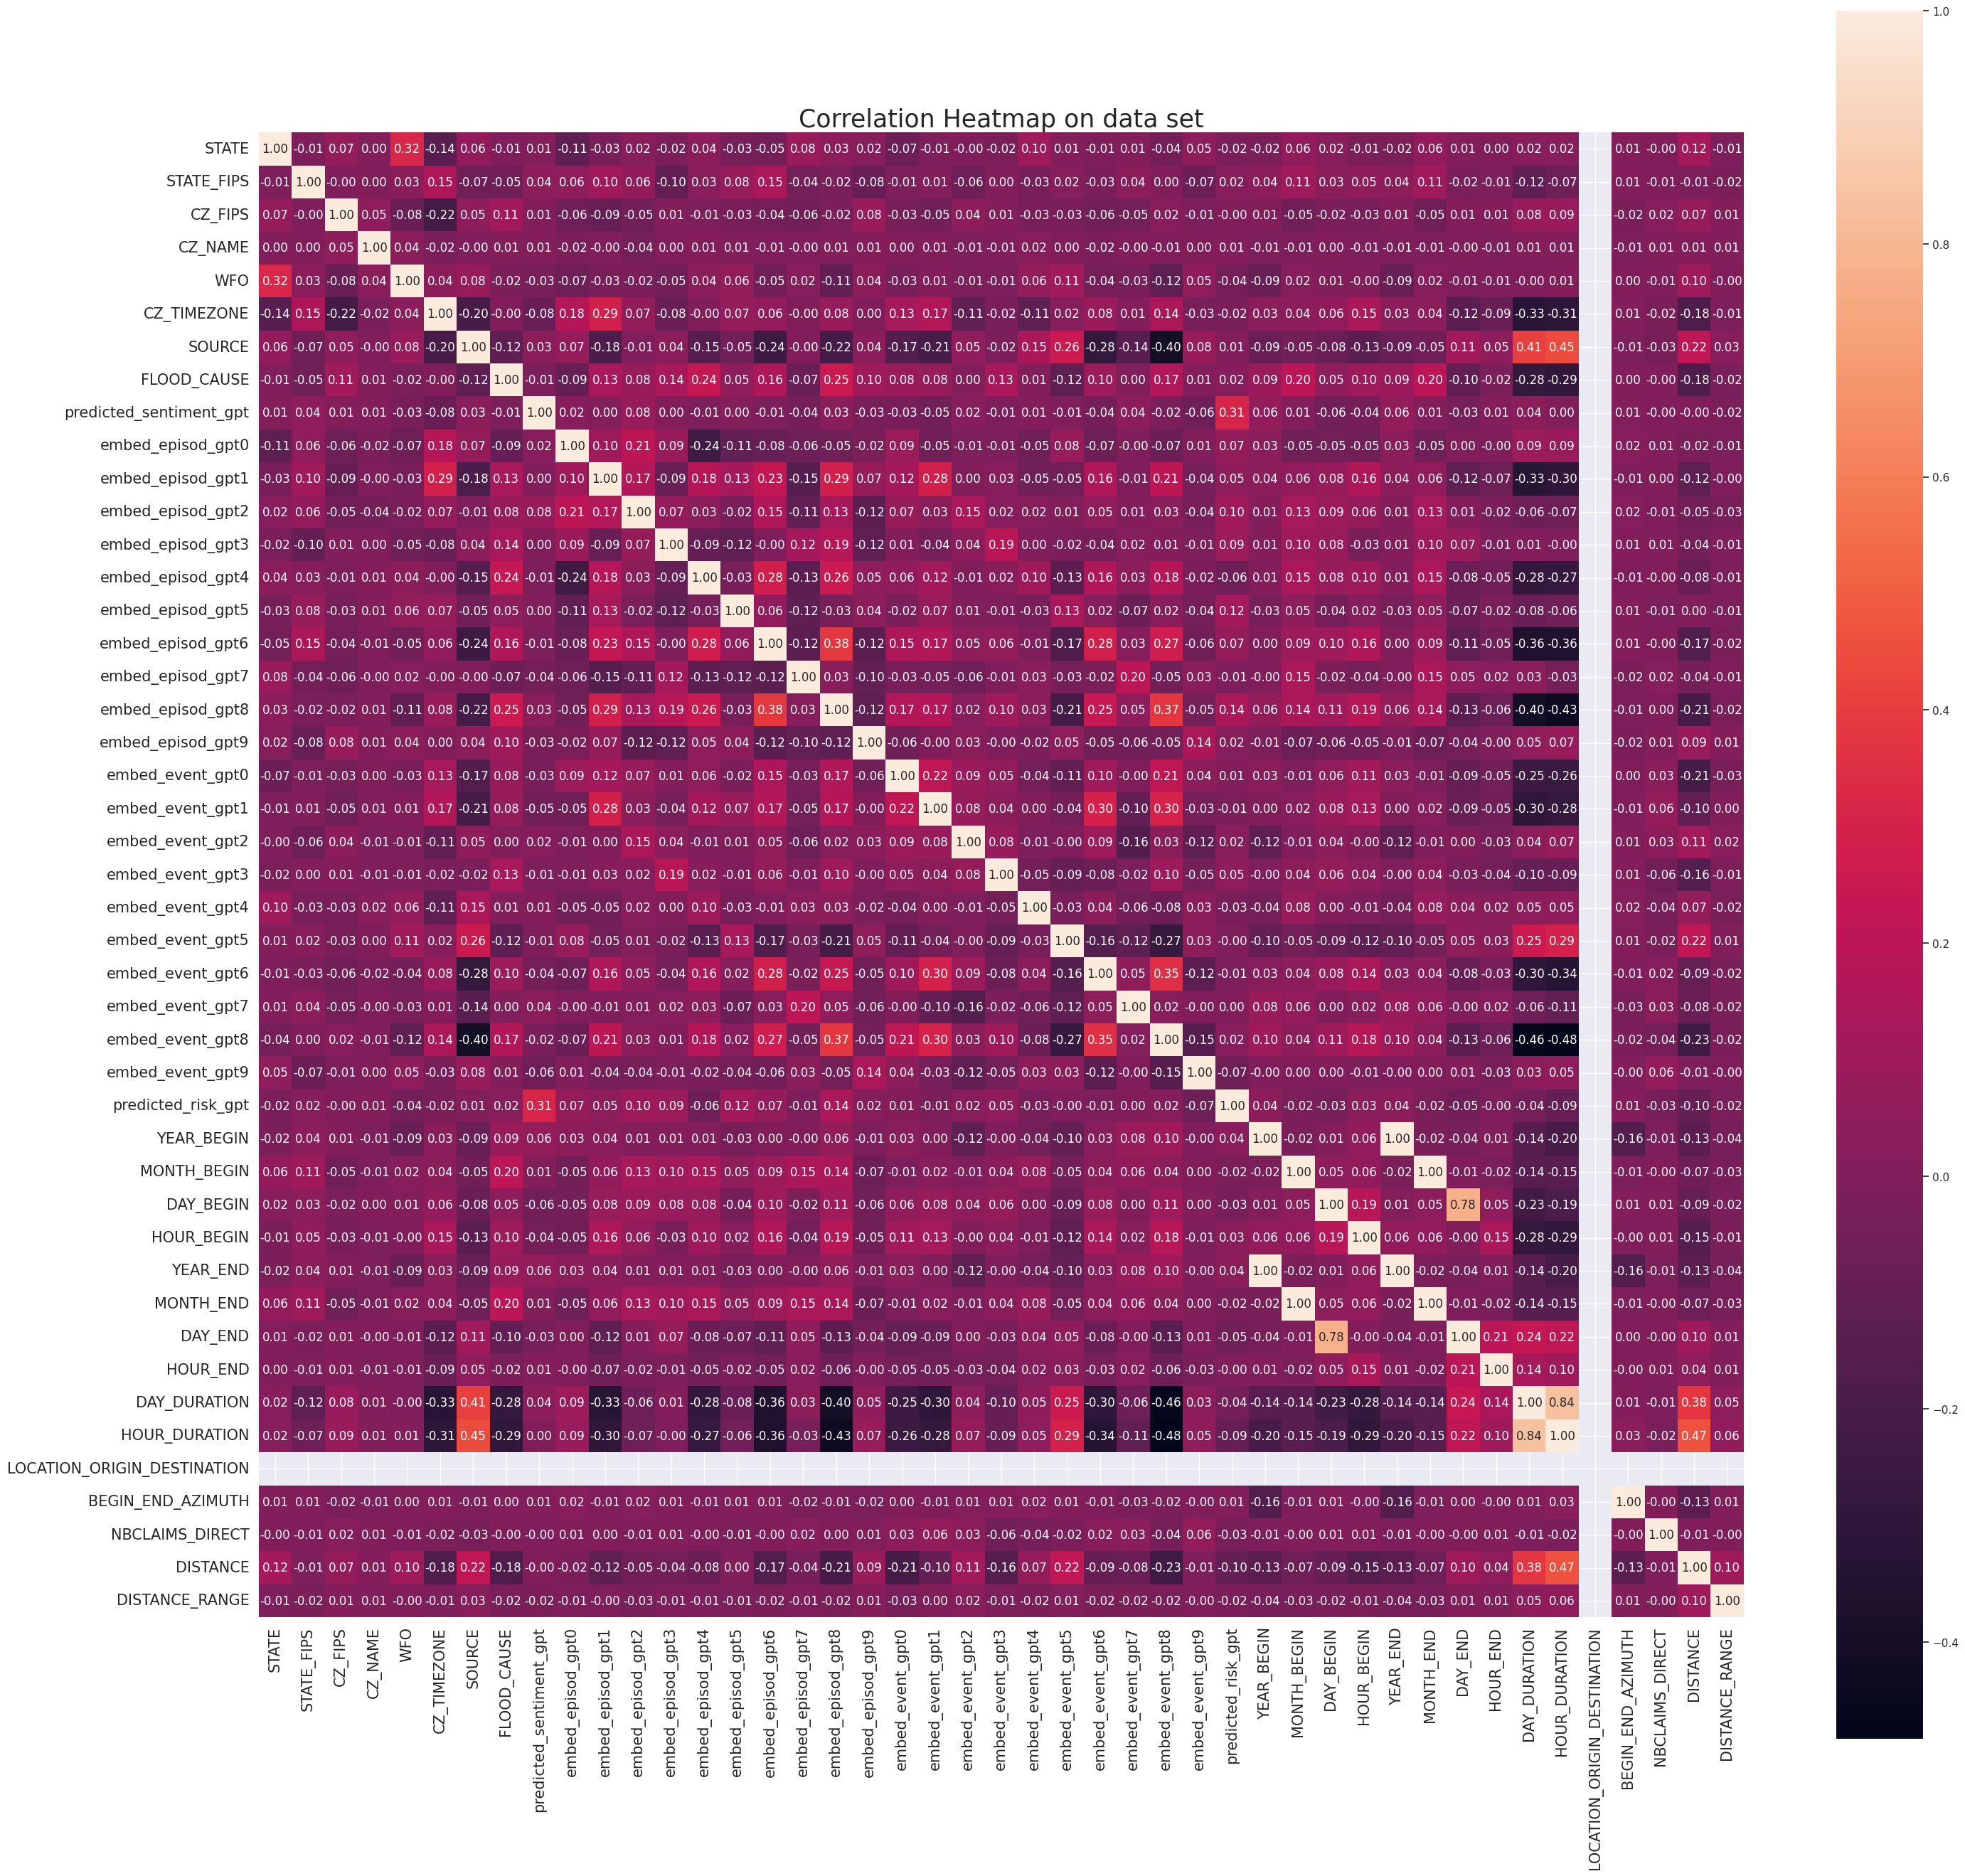

In [ ]:
# Correlation heatmap
corr_matrix = X_all.corr(method='spearman')
sns.set( rc = {'figure.figsize': (30, 30)})
plt.figure()
sns.heatmap(corr_matrix, square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=25)
plt.yticks(fontsize="15")
plt.xticks(fontsize="15")
plt.show()

In [ ]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['YEAR_END', 'MONTH_END', 'DAY_END', 'HOUR_DURATION']

In [ ]:
# Drop features
X_all_f = X_all.drop(X_all[to_drop], axis=1)

In [ ]:
# Look at the new data set
X_all_f.shape

(38036, 41)

### Standardization

In [ ]:
scaling=MinMaxScaler()

In [ ]:
num1_ = ['STATE_FIPS',
'CZ_FIPS',
'YEAR_BEGIN',
'MONTH_BEGIN',
'DAY_BEGIN',
'HOUR_BEGIN',
'HOUR_END',
'DAY_DURATION',
'DISTANCE',
'DISTANCE_RANGE',
'NBCLAIMS_DIRECT']

In [ ]:
num2_=['embed_episod_gpt0',
'embed_episod_gpt1',
'embed_episod_gpt2',
'embed_episod_gpt3',
'embed_episod_gpt4',
'embed_episod_gpt5',
'embed_episod_gpt6',
'embed_episod_gpt7',
'embed_episod_gpt8',
'embed_episod_gpt9',
'embed_event_gpt0',
'embed_event_gpt1',
'embed_event_gpt2',
'embed_event_gpt3',
'embed_event_gpt4',
'embed_event_gpt5',
'embed_event_gpt6',
'embed_event_gpt7',
'embed_event_gpt8',
'embed_event_gpt9']

In [ ]:
cat_=['STATE',
'CZ_NAME',
'WFO',
'CZ_TIMEZONE',
'SOURCE',
'FLOOD_CAUSE',
'BEGIN_END_AZIMUTH',
'LOCATION_ORIGIN_DESTINATION',
'predicted_sentiment_gpt',
'predicted_risk_gpt']

In [ ]:
cat_new=X_all_f[cat_]
num1_new=X_all_f[num1_]
num2_new=X_all_f[num2_]

In [ ]:
# Features to scale
num_sc=pd.DataFrame(scaling.fit_transform(num1_new),
columns = ['STATE_FIPS',
'CZ_FIPS',
'YEAR_BEGIN',
'MONTH_BEGIN',
'DAY_BEGIN',
'HOUR_BEGIN',
'HOUR_END',
'DAY_DURATION',
'DISTANCE',
'DISTANCE_RANGE',
'NBCLAIMS_DIRECT'], index=cat_new.index)

In [ ]:
# New scaled data set
X_all_sc = pd.concat([cat_new, num_sc, num2_new],axis='columns')

In [ ]:
# new dataset to fit
# Attach Target variable
all = pd.concat([target, X_all_f], axis=1)
# Attach Target variable
all_sc = pd.concat([target, X_all_sc], axis=1)


### Feature Engineering with Lag and Rolling Window Features

In [ ]:
def lag_feat(df, var):
  df_lag = df.copy()  # Create a copy of the original dataframe
  lags = [1,7,30,90, 180, 270, 365]
  outcomes = [var]
  df_lag=df_lag.assign(**{
      f'{col} (t-{lag})': df_lag[col].shift(lag)
      for lag in lags
      for col in outcomes})
  # Remove nan values
  df_lag = df_lag.dropna()
  return df_lag



In [ ]:
def win_feat(df_lag, var):
  windows = [7, 30]
  outcomes = [var]
  df_lag_win = df_lag.copy()
  for window in windows:
    for col in outcomes:
        df_lag_win[f"{col} (r_w-{window}) mean"] = df_lag_win[col].rolling(window=window).mean()
  # Remove nan values
  df_lag_win = df_lag_win.dropna()
  return df_lag_win


### Split data set

In [ ]:
# Split data set into train and test sets
train = all[all.index < '2020-01-01']
test = all[all.index >= '2020-01-01']

# Further split test set into individual years
test_2020 = test[test.index < '2021-01-01']
test_2021 = test[(test.index >= '2021-01-01') & (test.index < '2022-01-01')]
test_2022 = test[(test.index >= '2022-01-01') & (test.index < '2023-01-01')]


len(train), len(test), len(test_2020), len(test_2021), len(test_2022)

(31577, 6459, 2554, 2012, 1893)

In [ ]:
# Split scaled data set into train and test sets
train_sc = all_sc[all_sc.index < '2020-01-01']
test_sc = all_sc[all_sc.index >= '2020-01-01']

# Further split test set into individual years
test_2020_sc = test_sc[test_sc.index < '2021-01-01']
test_2021_sc = test_sc[(test_sc.index >= '2021-01-01') & (test_sc.index < '2022-01-01')]
test_2022_sc = test_sc[(test_sc.index >= '2022-01-01') & (test_sc.index < '2023-01-01')]


len(train_sc), len(test_sc), len(test_2020_sc), len(test_2021_sc), len(test_2022_sc)

(31577, 6459, 2554, 2012, 1893)

In [ ]:
# create lag and rolling window features on all dataset for t+1
all_t_1=pd.concat([train,test_2020],axis=0)
all_lag_t_1=lag_feat(all_t_1, 'A_DAMAGE_PROPERTY')
all_win_lag_t_1=win_feat(all_lag_t_1,'A_DAMAGE_PROPERTY')

# Split data set into train and test sets for t+1
train_t_1 = all_win_lag_t_1[all_win_lag_t_1.index < '2020-01-01']
test_t_1 = all_win_lag_t_1[all_win_lag_t_1.index >= '2020-01-01']

# split features from target for t+1
X_train_t_1 = train_t_1.copy()
y_train_t_1 = X_train_t_1.A_DAMAGE_PROPERTY
y_train_t_1 = pd.DataFrame(y_train_t_1, columns=['A_DAMAGE_PROPERTY'])
train_weights_t_1=X_train_t_1.NBCLAIMS_DIRECT
train_weights_t_1_df=pd.DataFrame(train_weights_t_1, index=y_train_t_1.index)
train_weights_t_1_df.rename(columns={'NBCLAIMS_DIRECT': 'WEIGHTS'}, inplace=True)
X_train_t_1.drop(['NBCLAIMS_DIRECT','A_DAMAGE_PROPERTY'], axis=1, inplace=True)
X_test_t_1 = test_t_1.copy()
y_test_t_1 = X_test_t_1.A_DAMAGE_PROPERTY
y_test_t_1 = pd.DataFrame(y_test_t_1, columns=['A_DAMAGE_PROPERTY'])
test_weights_t_1=X_test_t_1.NBCLAIMS_DIRECT
test_weights_t_1_df=pd.DataFrame(test_weights_t_1, index=y_test_t_1.index, columns=['WEIGHTS'])
test_weights_t_1_df.rename(columns={'NBCLAIMS_DIRECT': 'WEIGHTS'}, inplace=True)
X_test_t_1.drop(['A_DAMAGE_PROPERTY','NBCLAIMS_DIRECT'], axis=1, inplace=True)
test_weights_t_2 = test_2021.NBCLAIMS_DIRECT
test_weights_t_2_df = pd.DataFrame(test_weights_t_2, index=test_2021.index)
test_weights_t_2_df = pd.DataFrame(test_weights_t_2, index=test_2021.index)
test_weights_t_2_df.rename(columns={'NBCLAIMS_DIRECT': 'WEIGHTS'}, inplace=True)
test_weights_t_3 = test_2022.NBCLAIMS_DIRECT
test_weights_t_3_df = pd.DataFrame(test_weights_t_3, index=test_2022.index)
test_weights_t_3_df.rename(columns={'NBCLAIMS_DIRECT': 'WEIGHTS'}, inplace=True)






In [ ]:
# create lag and rolling window features on all scaling dataset for t+1
all_sc_t_1=pd.concat([train_sc,test_2020_sc],axis=0)
all_sc_lag_t_1=lag_feat(all_sc_t_1, 'A_DAMAGE_PROPERTY')
all_sc_win_lag_t_1=win_feat(all_sc_lag_t_1,'A_DAMAGE_PROPERTY')

# Split data set into train and test scaled sets for t+1
train_sc_t_1 = all_sc_win_lag_t_1[all_sc_win_lag_t_1.index < '2020-01-01']
test_sc_t_1 = all_sc_win_lag_t_1[all_sc_win_lag_t_1.index >= '2020-01-01']

# split features from target for t+1
X_train_sc_t_1 = train_sc_t_1.copy()
y_train_sc_t_1 = X_train_sc_t_1.A_DAMAGE_PROPERTY
y_train_sc_t_1 = pd.DataFrame(y_train_sc_t_1, columns=['A_DAMAGE_PROPERTY'])
train_weights_sc_t_1=X_train_sc_t_1.NBCLAIMS_DIRECT
train_weights_sc_t_1_df=pd.DataFrame(train_weights_sc_t_1, index=X_train_sc_t_1.index)
train_weights_sc_t_1_df.rename(columns={'NBCLAIMS_DIRECT': 'WEIGHTS'}, inplace=True)
X_train_sc_t_1.drop(['A_DAMAGE_PROPERTY','NBCLAIMS_DIRECT'], axis=1, inplace=True)
X_test_sc_t_1 = test_sc_t_1.copy()
y_test_sc_t_1 = X_test_sc_t_1.A_DAMAGE_PROPERTY
y_test_sc_t_1 = pd.DataFrame(y_test_sc_t_1, columns=['A_DAMAGE_PROPERTY'])
test_weights_sc_t_1=X_test_sc_t_1.NBCLAIMS_DIRECT
test_weights_sc_t_1_df=pd.DataFrame(test_weights_sc_t_1, index=y_test_t_1.index)
test_weights_sc_t_1_df.rename(columns={'NBCLAIMS_DIRECT': 'WEIGHTS'}, inplace=True)
X_test_sc_t_1.drop(['A_DAMAGE_PROPERTY','NBCLAIMS_DIRECT'], axis=1, inplace=True)
test_weights_sc_t_2 = test_2021.NBCLAIMS_DIRECT
test_weights_sc_t_2_df = pd.DataFrame(test_weights_sc_t_2, index=test_2021_sc.index)
test_weights_sc_t_2_df.rename(columns={'NBCLAIMS_DIRECT': 'WEIGHTS'}, inplace=True)
test_weights_sc_t_3 = test_2022.NBCLAIMS_DIRECT
test_weights_sc_t_3_df = pd.DataFrame(test_weights_sc_t_3, index=test_2022_sc.index)
test_weights_sc_t_3_df.rename(columns={'NBCLAIMS_DIRECT': 'WEIGHTS'}, inplace=True)


### Modelling & Evaluation

### Naive

#### Prediction step 1

In [ ]:
# Prediction t+1
score_naive_t_1 = []
y_train_t_1_=y_train_t_1.copy()
y_test_t_1_=y_test_t_1.copy()
y_train_t_1_['A_DAMAGE_PROPERTY_naive'] = y_train_t_1_['A_DAMAGE_PROPERTY'].shift(1)
y_test_t_1_['A_DAMAGE_PROPERTY_naive'] = y_test_t_1_['A_DAMAGE_PROPERTY'].shift(1)
predictions_tr_na_t_1 = y_train_t_1_.drop(columns="A_DAMAGE_PROPERTY")
predictions_te_na_t_1 = y_test_t_1_.drop(columns="A_DAMAGE_PROPERTY")
rmse_train = np.sqrt(mean_squared_error(y_train_t_1_.iloc[1:,0], predictions_tr_na_t_1.iloc[1:,0]))
rmse_test = np.sqrt(mean_squared_error(y_test_t_1_.iloc[1:,0], predictions_te_na_t_1.iloc[1:,0]))
mae_train = mean_absolute_error(y_train_t_1_.iloc[1:,0], predictions_tr_na_t_1.iloc[1:,0])
mae_test = mean_absolute_error(y_test_t_1_.iloc[1:,0], predictions_te_na_t_1.iloc[1:,0])
#mgd_train = mean_gamma_deviance(y_train_t_1_.iloc[1:,0], predictions_tr.iloc[1:,0])
#mgd_test = mean_gamma_deviance(y_test_t_1_.iloc[1:,0], predictions_te.iloc[1:,0])

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': 'N/A',
        'mgd_test': 'N/A'
    }

score_naive_t_1.append(score_dict)
score_naive_t_1 = pd.DataFrame(score_naive_t_1, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_tr_naive_t_1 = pd.DataFrame(predictions_tr_na_t_1, columns = ['A_DAMAGE_PROPERTY_naive'])
predictions_te_naive_t_1 = pd.DataFrame(predictions_te_na_t_1, columns = ['A_DAMAGE_PROPERTY_naive'])



#### Evaluation step 1

In [ ]:
naive_results_t_1 = {'step':['t+1'],
                'model':['naive'],
               'rmse_train':score_naive_t_1['rmse_train'],
               'rmse_test': score_naive_t_1['rmse_test'],
               'mae_train': score_naive_t_1['mae_train'],
               'mae_test': score_naive_t_1['mae_test'],
               'mgd_train': score_naive_t_1['mgd_train'],
               'mgd_test': score_naive_t_1['mgd_test']
               }
score_naive_t_1 = pd.DataFrame(naive_results_t_1,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_naive_t_1

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+1,naive,778.966123,313.378417,43.983067,12.220917,N/A,N/A


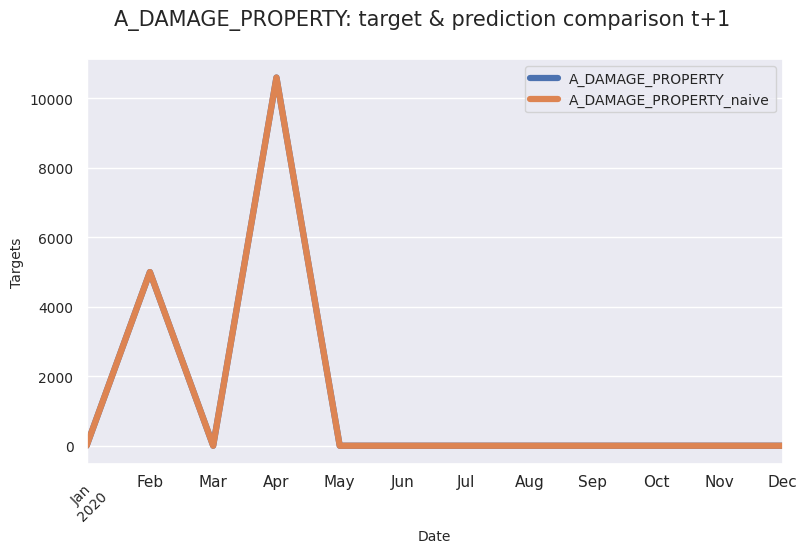

In [ ]:
# Plot results
test_df_na_t_1=test_2020.copy()
test_df_na_t_1 = pd.concat([test_df_na_t_1, predictions_te_naive_t_1.set_index(test_df_na_t_1.index)], axis=1)
test_df_na_t_1_agg = test_df_na_t_1.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_naive': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_na_t_1_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+1', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

#### Prediction step 2

In [ ]:
# create lag and window features on all dataset for t+1
test_df_pred_na_t_1 = test_df_na_t_1.copy()
test_df_pred_na_t_1.drop(['A_DAMAGE_PROPERTY'], axis=1, inplace=True)
test_df_pred_na_t_1.rename(columns={'A_DAMAGE_PROPERTY_naive': 'A_DAMAGE_PROPERTY'}, inplace=True)

# create lag and window features on all dataset for t+2
all_t_2=pd.concat([train,test_df_pred_na_t_1,test_2021],axis=0)
all_lag_t_2=lag_feat(all_t_2, 'A_DAMAGE_PROPERTY')
all_win_lag_t_2=win_feat(all_lag_t_2,'A_DAMAGE_PROPERTY')

# retrieve test set for t+2
test_t_2 = all_win_lag_t_2[(all_win_lag_t_2.index >= '2021-01-01') & (all_win_lag_t_2.index < '2022-01-01')]

# split features from target for t+2
X_test_t_2 = test_t_2.copy()
y_test_t_2 = X_test_t_2.A_DAMAGE_PROPERTY
y_test_t_2 = pd.DataFrame(y_test_t_2, columns=['A_DAMAGE_PROPERTY'])
X_test_t_2.drop(['A_DAMAGE_PROPERTY','NBCLAIMS_DIRECT'], axis=1, inplace=True)


In [ ]:
score_naive_t_2 = []
y_test_t_2_=y_test_t_2.copy()
y_test_t_2_['A_DAMAGE_PROPERTY_naive'] = y_test_t_2_['A_DAMAGE_PROPERTY'].shift(1)
predictions_te_na_t_2 = y_test_t_2_.drop(columns="A_DAMAGE_PROPERTY")
rmse_test = np.sqrt(mean_squared_error(y_test_t_2_.iloc[1:,0], predictions_te_na_t_2.iloc[1:,0]))
mae_test = mean_absolute_error(y_test_t_2_.iloc[1:,0], predictions_te_na_t_2.iloc[1:,0])
#mgd_test = mean_gamma_deviance(y_test_t_2_.iloc[1:,0], predictions_te.iloc[1:,0])

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': 'N/A',
        'mgd_test': 'N/A'
    }

score_naive_t_2.append(score_dict)
score_naive_t_2 = pd.DataFrame(score_naive_t_2, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_te_naive_t_2 = pd.DataFrame(predictions_te_na_t_2, columns = ['A_DAMAGE_PROPERTY_naive'])



#### Evaluation step 2

In [ ]:
naive_results_t_2 = {'step':['t+2'],
                'model':['naive'],
                'rmse_train':score_naive_t_2['rmse_train'],
                'rmse_test': score_naive_t_2['rmse_test'],
                'mae_train': score_naive_t_2['mae_train'],
                'mae_test': score_naive_t_2['mae_test'],
                'mgd_train': score_naive_t_2['mgd_train'],
                'mgd_test': score_naive_t_2['mgd_test']
               }
score_naive_t_2 = pd.DataFrame(naive_results_t_2,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_naive_t_2

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+2,naive,778.966123,653.187114,43.983067,26.852312,N/A,N/A


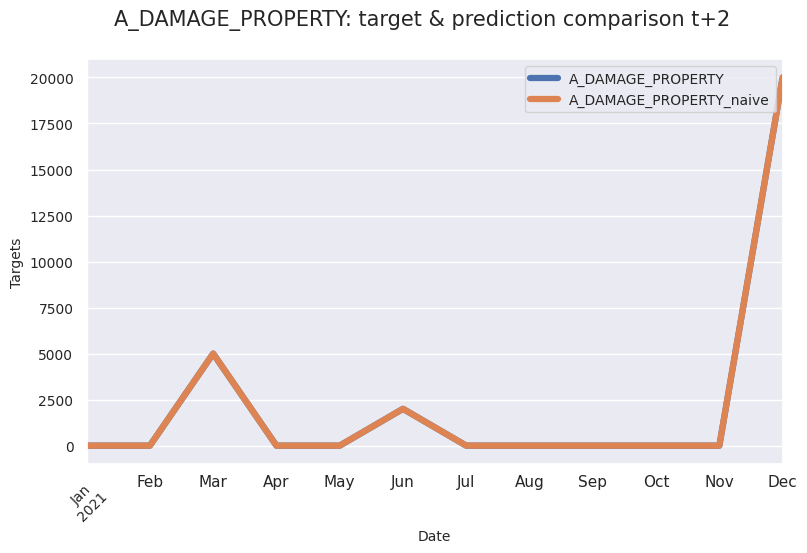

In [ ]:
# Plot results
test_df_na_t_2=test_2021.copy()
test_df_na_t_2 = pd.concat([test_df_na_t_2, predictions_te_naive_t_2.set_index(test_df_na_t_2.index)], axis=1)
test_df_na_t_2_agg = test_df_na_t_2.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_naive': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_na_t_2_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+2', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

#### Prediction step 3

In [ ]:
# create lag and window features on all dataset for t+1
test_df_pred_na_t_2 = test_df_na_t_2.copy()
test_df_pred_na_t_2.drop(['A_DAMAGE_PROPERTY'], axis=1, inplace=True)
test_df_pred_na_t_2.rename(columns={'A_DAMAGE_PROPERTY_naive': 'A_DAMAGE_PROPERTY'}, inplace=True)

# create lag and window features on all dataset for t+2
all_t_3=pd.concat([train,test_df_pred_na_t_1,test_df_pred_na_t_2,test_2022],axis=0)
all_lag_t_3=lag_feat(all_t_3, 'A_DAMAGE_PROPERTY')
all_win_lag_t_3=win_feat(all_lag_t_3,'A_DAMAGE_PROPERTY')

# retrieve test set for t+2
test_t_3 = all_win_lag_t_3[(all_win_lag_t_3.index >= '2022-01-01') & (all_win_lag_t_3.index < '2023-01-01')]

# split features from target for t+2
X_test_t_3 = test_t_3.copy()
y_test_t_3 = X_test_t_3.A_DAMAGE_PROPERTY
y_test_t_3 = pd.DataFrame(y_test_t_3, columns=['A_DAMAGE_PROPERTY'])
X_test_t_3.drop(['A_DAMAGE_PROPERTY','NBCLAIMS_DIRECT'], axis=1, inplace=True)


In [ ]:
score_naive_t_3 = []
y_test_t_3_=y_test_t_3.copy()
y_test_t_3_['A_DAMAGE_PROPERTY_naive'] = y_test_t_3_['A_DAMAGE_PROPERTY'].shift(1)
predictions_te_na_t_3 = y_test_t_3_.drop(columns="A_DAMAGE_PROPERTY")
rmse_test = np.sqrt(mean_squared_error(y_test_t_3_.iloc[1:,0], predictions_te_na_t_3.iloc[1:,0]))
mae_test = mean_absolute_error(y_test_t_3_.iloc[1:,0], predictions_te_na_t_3.iloc[1:,0])
#mgd_test = mean_gamma_deviance(y_test_t_3_.iloc[1:,0], predictions_te.iloc[1:,0])

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': 'N/A',
        'mgd_test': 'N/A'
    }

score_naive_t_3.append(score_dict)
score_naive_t_3 = pd.DataFrame(score_naive_t_3, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_te_naive_t_3 = pd.DataFrame(predictions_te_na_t_3, columns = ['A_DAMAGE_PROPERTY_naive'])


#### Evaluation step 3

In [ ]:
naive_results_t_3 = {'step':['t+3'],
                'model':['naive'],
                'rmse_train':score_naive_t_3['rmse_train'],
                'rmse_test': score_naive_t_3['rmse_test'],
                'mae_train': score_naive_t_3['mae_train'],
                'mae_test': score_naive_t_3['mae_test'],
                'mgd_train': score_naive_t_3['mgd_train'],
                'mgd_test': score_naive_t_3['mgd_test']
               }
score_naive_t_3 = pd.DataFrame(naive_results_t_3,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_naive_t_3

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+3,naive,778.966123,325.128044,43.983067,10.570825,N/A,N/A


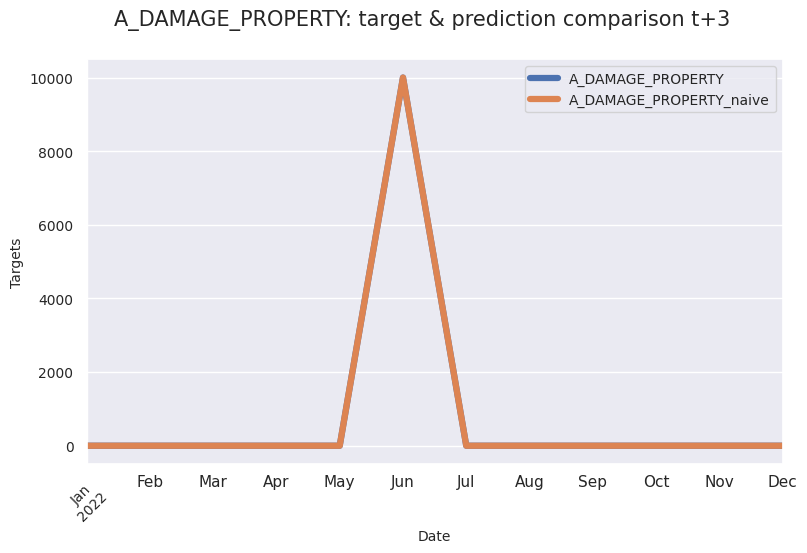

In [ ]:
# Plot results
test_df_na_t_3=test_2022.copy()
test_df_na_t_3 = pd.concat([test_df_na_t_3, predictions_te_naive_t_3.set_index(test_df_na_t_3.index)], axis=1)
test_df_na_t_3_agg = test_df_na_t_3.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_naive': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_na_t_3_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+3', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

### GLM

#### Fine-Tuning

In [ ]:
#def objective(trial):
#    params = {
#        'power': trial.suggest_loguniform('power', 1.5, 2),
#        'link':'log'
#    }
#    np.random.seed(0)
#    glm = TweedieRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)
#    mgd_scores = []

#    for train_index, val_index in tscv.split(X_train_sc_t_1):
#        X_tr, X_val, tr_weights_sc = X_train_sc_t_1.iloc[train_index], X_train_sc_t_1.iloc[val_index], train_weights_sc_t_1[train_index]
#        y_tr, y_val = y_train_sc_t_1.iloc[train_index], y_train_sc_t_1.iloc[val_index]

#        glm.fit(X_tr, np.maximum(y_tr,1e-12), sample_weight=tr_weights_sc)
#        pred_val = glm.predict(X_val)

#        mgd_score = mean_gamma_deviance(np.maximum(y_val,1e-12), pred_val)
#        mgd_scores.append(mgd_score)

#    return np.mean(mgd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params


In [ ]:
#best_params

#### Fit model

In [ ]:
np.random.seed(0)
glm_tuned = TweedieRegressor(power=1.617687737249122, link='log') # GLM with compound Poisson-Gamma distribution
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
glm_model = GridSearchCV(glm_tuned,param_grid,cv=tscv)
glm_tuned=glm_model.fit(X_train_sc_t_1, np.maximum(y_train_sc_t_1,1e-12),sample_weight=train_weights_sc_t_1)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l

#### Prediction step 1

In [ ]:
# Prediction t+1
score_glm_t_1 = []
predictions_tr_glm_t_1 = glm_tuned.predict(X_train_sc_t_1)
predictions_te_glm_t_1 = glm_tuned.predict(X_test_sc_t_1)
rmse_train = np.sqrt(mean_squared_error(y_train_sc_t_1, predictions_tr_glm_t_1))
rmse_test = np.sqrt(mean_squared_error(y_test_sc_t_1, predictions_te_glm_t_1))
mae_train = mean_absolute_error(y_train_sc_t_1, predictions_tr_glm_t_1)
mae_test = mean_absolute_error(y_test_sc_t_1, predictions_te_glm_t_1)
mgd_train = mean_gamma_deviance(np.maximum(y_train_sc_t_1, 1e-12), predictions_tr_glm_t_1)
mgd_test = mean_gamma_deviance(np.maximum(y_test_sc_t_1,1e-12), predictions_te_glm_t_1)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test
    }

score_glm_t_1.append(score_dict)
score_glm_t_1 = pd.DataFrame(score_glm_t_1, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_tr_glm_t_1 = pd.DataFrame(predictions_tr_glm_t_1, columns = ['A_DAMAGE_PROPERTY_glm'])
predictions_te_glm_t_1 = pd.DataFrame(predictions_te_glm_t_1, columns = ['A_DAMAGE_PROPERTY_glm'])


#### Evaluation step 1

In [ ]:
glm_results_t_1 = {'step':['t+1'],
                'model':['glm'],
               'rmse_train':score_glm_t_1['rmse_train'],
               'rmse_test': score_glm_t_1['rmse_test'],
              'mae_train': score_glm_t_1['mae_train'],
              'mae_test': score_glm_t_1['mae_test'],
               'mgd_train': score_glm_t_1['mgd_train'],
               'mgd_test': score_glm_t_1['mgd_test']
               }
score_glm_t_1 = pd.DataFrame(glm_results_t_1,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_glm_t_1

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+1,glm,2951.8006,2924.297191,2931.789907,2923.069021,69.071048,69.142471


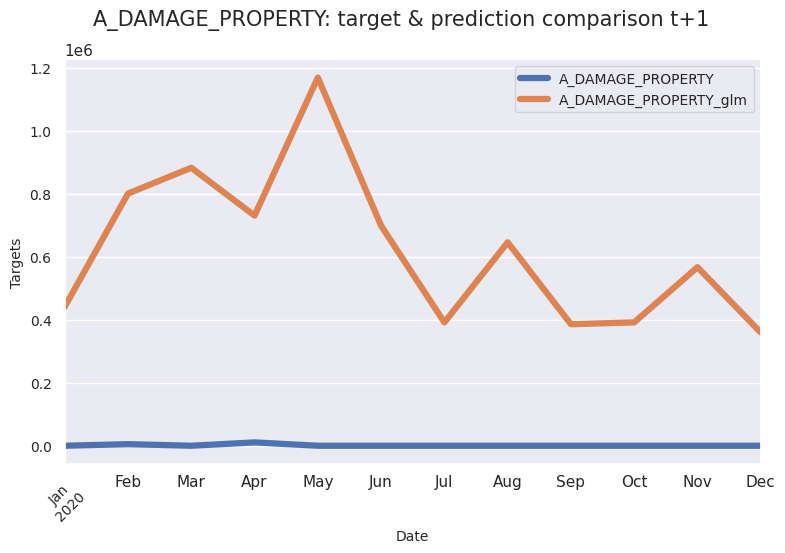

In [ ]:
# Plot results
test_df_glm_t_1=test_2020_sc.copy()
test_df_glm_t_1 = pd.concat([test_df_glm_t_1, predictions_te_glm_t_1.set_index(test_df_glm_t_1.index)], axis=1)
test_df_glm_t_1_agg = test_df_glm_t_1.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_glm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_glm_t_1_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+1', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

#### Prediction step 2

In [ ]:
# create lag and window features on all dataset for t+1
test_df_pred_glm_t_1 = test_df_glm_t_1.copy()
test_df_pred_glm_t_1.drop(['A_DAMAGE_PROPERTY'], axis=1, inplace=True)
test_df_pred_glm_t_1.rename(columns={'A_DAMAGE_PROPERTY_glm': 'A_DAMAGE_PROPERTY'}, inplace=True)

# create lag and window features on all dataset for t+2
all_sc_t_2=pd.concat([train_sc,test_df_pred_glm_t_1,test_2021_sc],axis=0)
all_sc_lag_t_2=lag_feat(all_sc_t_2, 'A_DAMAGE_PROPERTY')
all_sc_win_lag_t_2=win_feat(all_sc_lag_t_2,'A_DAMAGE_PROPERTY')

# retrieve test set for t+2
test_sc_t_2 = all_sc_win_lag_t_2[(all_sc_win_lag_t_2.index >= '2021-01-01') & (all_sc_win_lag_t_2.index < '2022-01-01')]

# split features from target for t+2
X_test_sc_t_2 = test_sc_t_2.copy()
y_test_sc_t_2 = X_test_sc_t_2.A_DAMAGE_PROPERTY
y_test_sc_t_2 = pd.DataFrame(y_test_sc_t_2, columns=['A_DAMAGE_PROPERTY'])
X_test_sc_t_2.drop(['A_DAMAGE_PROPERTY','NBCLAIMS_DIRECT'], axis=1, inplace=True)


In [ ]:
score_glm_t_2 = []
predictions_te_glm_t_2 = glm_tuned.predict(X_test_sc_t_2)
rmse_test = np.sqrt(mean_squared_error(y_test_sc_t_2, predictions_te_glm_t_2))
mae_test = mean_absolute_error(y_test_sc_t_2, predictions_te_glm_t_2)
mgd_test = mean_gamma_deviance(np.maximum(y_test_sc_t_2,1e-12), predictions_te_glm_t_2)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test
    }

score_glm_t_2.append(score_dict)
score_glm_t_2 = pd.DataFrame(score_glm_t_2, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_te_glm_t_2 = pd.DataFrame(predictions_te_glm_t_2, columns = ['A_DAMAGE_PROPERTY_glm'])


#### Evaluation step 2

In [ ]:
glm_results_t_2 = {'step':['t+2'],
                'model':['glm'],
               'rmse_train':score_glm_t_2['rmse_train'],
               'rmse_test': score_glm_t_2['rmse_test'],
              'mae_train': score_glm_t_2['mae_train'],
              'mae_test': score_glm_t_2['mae_test'],
               'mgd_train': score_glm_t_2['mgd_train'],
               'mgd_test': score_glm_t_2['mgd_test']
               }
score_glm_t_2 = pd.DataFrame(glm_results_t_2,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_glm_t_2

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+2,glm,2951.8006,2944.982668,2931.789907,2927.629421,69.071048,69.123014


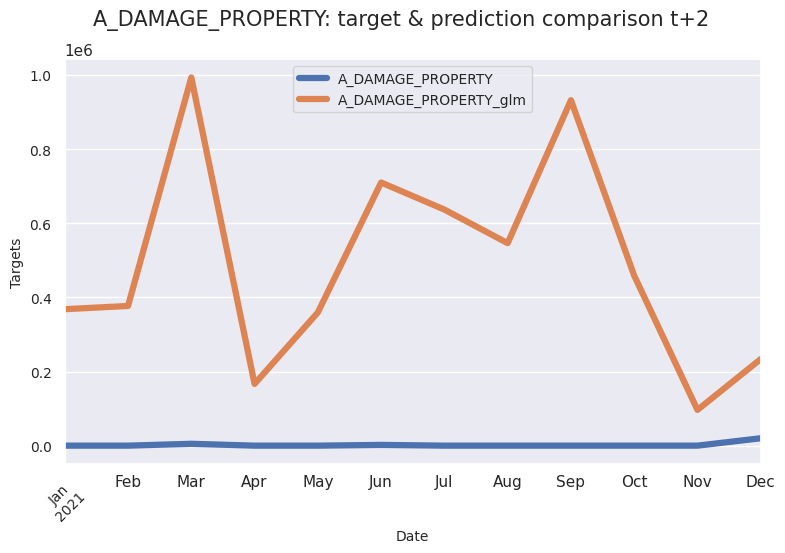

In [ ]:
# Plot results
test_df_glm_t_2=test_2021_sc.copy()
test_df_glm_t_2 = pd.concat([test_df_glm_t_2, predictions_te_glm_t_2.set_index(test_df_glm_t_2.index)], axis=1)
test_df_glm_t_2_agg = test_df_glm_t_2.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_glm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_glm_t_2_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+2', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

#### Prediction step 3

In [ ]:
# create lag and window features on all dataset for t+3
test_df_pred_glm_t_2 = test_df_glm_t_2.copy()
test_df_pred_glm_t_2.drop(['A_DAMAGE_PROPERTY'], axis=1, inplace=True)
test_df_pred_glm_t_2.rename(columns={'A_DAMAGE_PROPERTY_glm': 'A_DAMAGE_PROPERTY'}, inplace=True)

# create lag and window features on all dataset for t+3
all_sc_t_3=pd.concat([train_sc,test_df_pred_glm_t_1,test_df_pred_glm_t_2,test_2022_sc],axis=0)
all_sc_lag_t_3=lag_feat(all_sc_t_3, 'A_DAMAGE_PROPERTY')
all_sc_win_lag_t_3=win_feat(all_sc_lag_t_3,'A_DAMAGE_PROPERTY')

# retrieve test set for t+3
test_sc_t_3 = all_sc_win_lag_t_3[(all_sc_win_lag_t_3.index >= '2022-01-01') & (all_sc_win_lag_t_3.index < '2023-01-01')]

# split features from target for t+3
X_test_sc_t_3 = test_sc_t_3.copy()
y_test_sc_t_3 = X_test_sc_t_3.A_DAMAGE_PROPERTY
y_test_sc_t_3 = pd.DataFrame(y_test_sc_t_3, columns=['A_DAMAGE_PROPERTY'])
X_test_sc_t_3.drop(['A_DAMAGE_PROPERTY','NBCLAIMS_DIRECT'], axis=1, inplace=True)


In [ ]:
score_glm_t_3 = []
predictions_te_glm_t_3 = glm_tuned.predict(X_test_sc_t_3)
rmse_test = np.sqrt(mean_squared_error(y_test_sc_t_3, predictions_te_glm_t_3))
mae_test = mean_absolute_error(y_test_sc_t_3, predictions_te_glm_t_3)
mgd_test = mean_gamma_deviance(np.maximum(y_test_sc_t_3,1e-12), predictions_te_glm_t_3)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test
    }

score_glm_t_3.append(score_dict)
score_glm_t_3 = pd.DataFrame(score_glm_t_3, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_te_glm_t_3 = pd.DataFrame(predictions_te_glm_t_3, columns = ['A_DAMAGE_PROPERTY_glm'])


#### Evaluation step 3

In [ ]:
glm_results_t_3 = {'step':['t+3'],
                'model':['glm'],
               'rmse_train':score_glm_t_3['rmse_train'],
               'rmse_test': score_glm_t_3['rmse_test'],
              'mae_train': score_glm_t_3['mae_train'],
              'mae_test': score_glm_t_3['mae_test'],
               'mgd_train': score_glm_t_3['mgd_train'],
               'mgd_test': score_glm_t_3['mgd_test']
               }
score_glm_t_3 = pd.DataFrame(glm_results_t_3,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_glm_t_3

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+3,glm,2951.8006,2925.761505,2931.789907,2924.202618,69.071048,69.186786


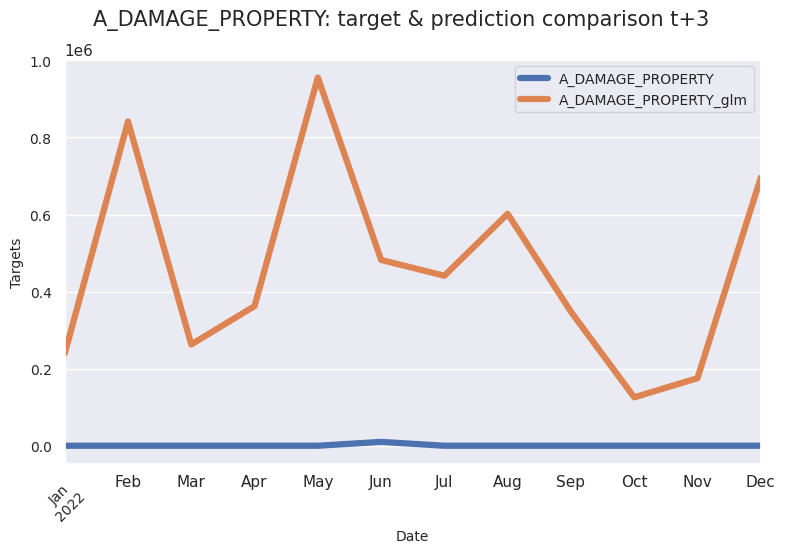

In [ ]:
# Plot results
test_df_glm_t_3=test_2022_sc.copy()
test_df_glm_t_3 = pd.concat([test_df_glm_t_3, predictions_te_glm_t_3.set_index(test_df_glm_t_3.index)], axis=1)
test_df_glm_t_3_agg = test_df_glm_t_3.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_glm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_glm_t_3_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+3', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()




### LightGBM

#### Fine-tune the model

In [ ]:
# Fine-tuning

#def objective(trial):
#    params = {
#        'objective': 'tweedie',
#        'random_state': 0,
#        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#        'max_depth': trial.suggest_int('max_depth', 3, 8),
#        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#       'tweedie_variance_power':trial.suggest_loguniform('tweedie_variance_power', 1.5, 2)
#    }

#    lgbm = LGBMRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)
#    mgd_scores = []

#    for train_index, val_index in tscv.split(X_train_t_1):
#        X_tr, X_val, tr_weigths = X_train_t_1.iloc[train_index], X_train_t_1.iloc[val_index], train_weights_t_1.iloc[train_index]
#        y_tr, y_val = y_train_t_1.iloc[train_index], y_train_t_1.iloc[val_index]

#        lgbm.fit(X_tr, np.maximum(y_tr,1e-12), sample_weight=tr_weigths)
#        pred_val = lgbm.predict(X_val)
#        pred_val = np.maximum(pred_val,1e-12)

#        mgd_score = mean_gamma_deviance(np.maximum(y_val,1e-12), pred_val)
#        mgd_scores.append(mgd_score)

#    return np.mean(mgd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params


In [ ]:
#best_params

#### Fit the model

In [ ]:
lgbm_model =  LGBMRegressor(
n_estimators= 710,
learning_rate= 0.016944406597277983,
max_depth= 3,
num_leaves= 127,
min_child_samples= 20,
objective='tweedie',
tweedie_variance_power= 1.702050609345177,
random_state=0)
lgbm_tuned=lgbm_model.fit(X_train_t_1, y_train_t_1, sample_weight=train_weights_t_1)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5993
[LightGBM] [Info] Number of data points in the train set: 31183, number of used features: 48
[LightGBM] [Info] Start training from score 7.980026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

#### Prediction step 1

In [ ]:
# Prediction t+1
score_lgbm_t_1 = []
predictions_tr_lgbm_t_1 = lgbm_tuned.predict(X_train_t_1)
predictions_te_lgbm_t_1 = lgbm_tuned.predict(X_test_t_1)
rmse_train = np.sqrt(mean_squared_error(y_train_t_1, predictions_tr_lgbm_t_1))
rmse_test = np.sqrt(mean_squared_error(y_test_t_1, predictions_te_lgbm_t_1))
mae_train = mean_absolute_error(y_train_t_1, predictions_tr_lgbm_t_1)
mae_test = mean_absolute_error(y_test_t_1, predictions_te_lgbm_t_1)
mgd_train = mean_gamma_deviance(np.maximum(y_train_t_1,1e-12), predictions_tr_lgbm_t_1)
mgd_test = mean_gamma_deviance(np.maximum(y_test_t_1,1e-12), predictions_te_lgbm_t_1)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test
    }

score_lgbm_t_1.append(score_dict)
score_lgbm_t_1 = pd.DataFrame(score_lgbm_t_1, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_tr_lgbm_t_1 = pd.DataFrame(predictions_tr_lgbm_t_1, columns = ['A_DAMAGE_PROPERTY_lgbm'])
predictions_te_lgbm_t_1 = pd.DataFrame(predictions_te_lgbm_t_1, columns = ['A_DAMAGE_PROPERTY_lgbm'])


#### Evaluation step 1

In [ ]:
lgbm_results_t_1 = {'step':['t+1'],
                'model':['lgbm'],
               'rmse_train':score_lgbm_t_1['rmse_train'],
               'rmse_test': score_lgbm_t_1['rmse_test'],
              'mae_train': score_lgbm_t_1['mae_train'],
              'mae_test': score_lgbm_t_1['mae_test'],
               'mgd_train': score_lgbm_t_1['mgd_train'],
               'mgd_test': score_lgbm_t_1['mgd_test']
               }
score_lgbm_t_1 = pd.DataFrame(lgbm_results_t_1,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_lgbm_t_1

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+1,lgbm,1039.626672,516.423548,94.787978,34.125705,15.706429,15.346222


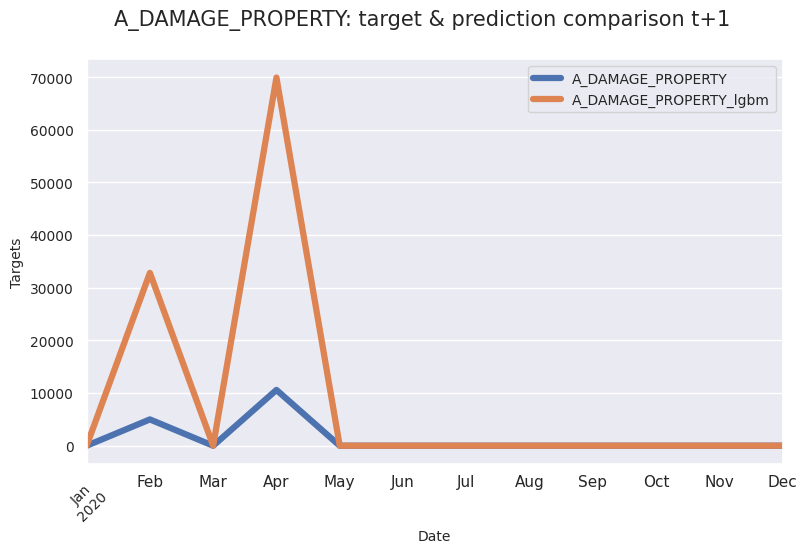

In [ ]:
# Plot results
test_df_lgbm_t_1=test_2020.copy()
test_df_lgbm_t_1 = pd.concat([test_df_lgbm_t_1, predictions_te_lgbm_t_1.set_index(test_df_lgbm_t_1.index)], axis=1)
test_df_lgbm_t_1_agg = test_df_lgbm_t_1.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_lgbm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_lgbm_t_1_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+1', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

#### Prediction step 2

In [ ]:
# create lag and window features on all dataset for t+1
test_df_pred_lgbm_t_1 = test_df_lgbm_t_1.copy()
test_df_pred_lgbm_t_1.drop(['A_DAMAGE_PROPERTY'], axis=1, inplace=True)
test_df_pred_lgbm_t_1.rename(columns={'A_DAMAGE_PROPERTY_lgbm': 'A_DAMAGE_PROPERTY'}, inplace=True)

# create lag and window features on all dataset for t+2
all_t_2=pd.concat([train_sc,test_df_pred_lgbm_t_1,test_2021],axis=0)
all_lag_t_2=lag_feat(all_t_2, 'A_DAMAGE_PROPERTY')
all_win_lag_t_2=win_feat(all_lag_t_2,'A_DAMAGE_PROPERTY')

# retrieve test set for t+2
test_t_2 = all_win_lag_t_2[(all_win_lag_t_2.index >= '2021-01-01') & (all_win_lag_t_2.index < '2022-01-01')]

# split features from target for t+2
X_test_t_2 = test_t_2.copy()
y_test_t_2 = X_test_t_2.A_DAMAGE_PROPERTY
y_test_t_2 = pd.DataFrame(y_test_t_2, columns=['A_DAMAGE_PROPERTY'])
X_test_t_2.drop(['A_DAMAGE_PROPERTY','NBCLAIMS_DIRECT'], axis=1, inplace=True)


In [ ]:
score_lgbm_t_2 = []
predictions_te_lgbm_t_2 = lgbm_tuned.predict(X_test_t_2)
rmse_test = np.sqrt(mean_squared_error(y_test_t_2, predictions_te_lgbm_t_2))
mae_test = mean_absolute_error(y_test_t_2, predictions_te_lgbm_t_2)
mgd_test = mean_gamma_deviance(np.maximum(y_test_t_2,1e-12), predictions_te_lgbm_t_2)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test
    }

score_lgbm_t_2.append(score_dict)
score_lgbm_t_2 = pd.DataFrame(score_lgbm_t_2, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_te_lgbm_t_2 = pd.DataFrame(predictions_te_lgbm_t_2, columns = ['A_DAMAGE_PROPERTY_lgbm'])


#### Evaluation step 2

In [ ]:
lgbm_results_t_2 = {'step':['t+2'],
                'model':['lgbm'],
               'rmse_train':score_lgbm_t_2['rmse_train'],
               'rmse_test': score_lgbm_t_2['rmse_test'],
              'mae_train': score_lgbm_t_2['mae_train'],
              'mae_test': score_lgbm_t_2['mae_test'],
               'mgd_train': score_lgbm_t_2['mgd_train'],
               'mgd_test': score_lgbm_t_2['mgd_test']
               }
score_lgbm_t_2 = pd.DataFrame(lgbm_results_t_2,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_lgbm_t_2

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+2,lgbm,1039.626672,523.980737,94.787978,40.005036,15.706429,15.381059


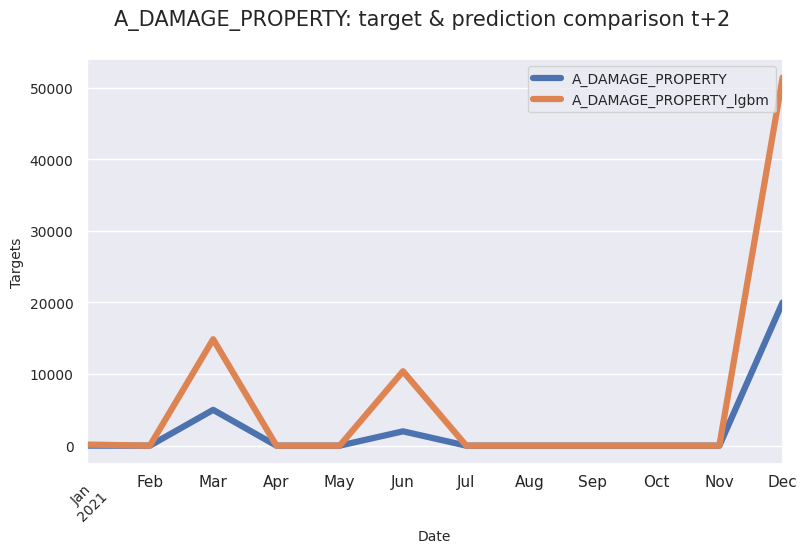

In [ ]:
# Plot results
test_df_lgbm_t_2=test_2021.copy()
test_df_lgbm_t_2 = pd.concat([test_df_lgbm_t_2, predictions_te_lgbm_t_2.set_index(test_df_lgbm_t_2.index)], axis=1)
test_df_lgbm_t_2_agg = test_df_lgbm_t_2.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_lgbm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_lgbm_t_2_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+2', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

#### Prediction step 3

In [ ]:
# create lag and window features on all dataset for t+3
test_df_pred_lgbm_t_2 = test_df_lgbm_t_2.copy()
test_df_pred_lgbm_t_2.drop(['A_DAMAGE_PROPERTY'], axis=1, inplace=True)
test_df_pred_lgbm_t_2.rename(columns={'A_DAMAGE_PROPERTY_lgbm': 'A_DAMAGE_PROPERTY'}, inplace=True)

# create lag and window features on all dataset for t+3
all_t_3=pd.concat([train,test_df_pred_lgbm_t_1,test_df_pred_lgbm_t_2,test_2022],axis=0)
all_lag_t_3=lag_feat(all_t_3, 'A_DAMAGE_PROPERTY')
all_win_lag_t_3=win_feat(all_lag_t_3,'A_DAMAGE_PROPERTY')

# retrieve test set for t+3
test_t_3 = all_win_lag_t_3[(all_win_lag_t_3.index >= '2022-01-01') & (all_win_lag_t_3.index < '2023-01-01')]

# split features from target for t+3
X_test_t_3 = test_t_3.copy()
y_test_t_3 = X_test_t_3.A_DAMAGE_PROPERTY
y_test_t_3 = pd.DataFrame(y_test_t_3, columns=['A_DAMAGE_PROPERTY'])
X_test_t_3.drop(['A_DAMAGE_PROPERTY','NBCLAIMS_DIRECT'], axis=1, inplace=True)


In [ ]:
score_lgbm_t_3 = []
predictions_te_lgbm_t_3 = lgbm_tuned.predict(X_test_t_3)
rmse_test = np.sqrt(mean_squared_error(y_test_t_3, predictions_te_lgbm_t_3))
mae_test = mean_absolute_error(y_test_t_3, predictions_te_lgbm_t_3)
mgd_test = mean_gamma_deviance(np.maximum(y_test_t_3,1e-12), predictions_te_lgbm_t_3)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test
    }

score_lgbm_t_3.append(score_dict)
score_lgbm_t_3 = pd.DataFrame(score_lgbm_t_3, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_te_lgbm_t_3 = pd.DataFrame(predictions_te_lgbm_t_3, columns = ['A_DAMAGE_PROPERTY_lgbm'])


#### Evaluation step 3

In [ ]:
lgbm_results_t_3 = {'step':['t+3'],
                'model':['lgbm'],
               'rmse_train':score_lgbm_t_3['rmse_train'],
               'rmse_test': score_lgbm_t_3['rmse_test'],
              'mae_train': score_lgbm_t_3['mae_train'],
              'mae_test': score_lgbm_t_3['mae_test'],
               'mgd_train': score_lgbm_t_3['mgd_train'],
               'mgd_test': score_lgbm_t_3['mgd_test']
               }
score_lgbm_t_3 = pd.DataFrame(lgbm_results_t_3,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_lgbm_t_3

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+3,lgbm,1039.626672,462.107608,94.787978,25.542506,15.706429,14.956231


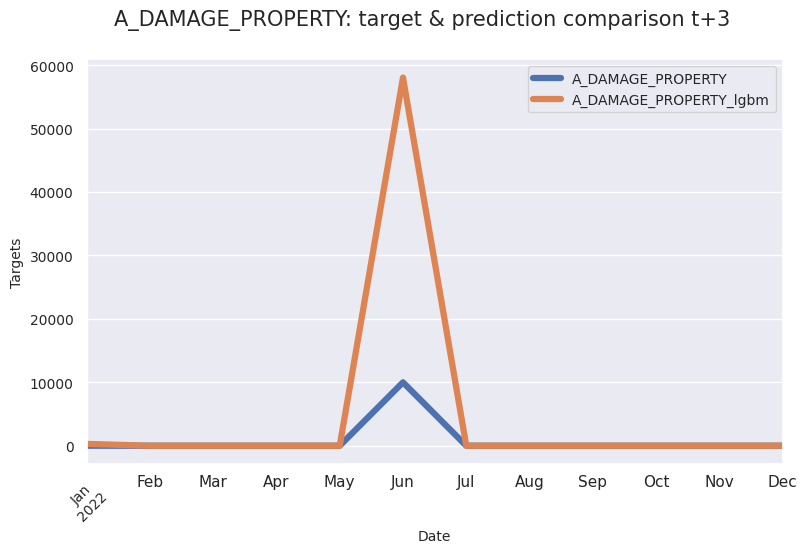

In [ ]:
# Plot results
test_df_lgbm_t_3=test_2022.copy()
test_df_lgbm_t_3 = pd.concat([test_df_lgbm_t_3, predictions_te_lgbm_t_3.set_index(test_df_lgbm_t_3.index)], axis=1)
test_df_lgbm_t_3_agg = test_df_lgbm_t_3.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_lgbm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_lgbm_t_3_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+3', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

### NN

#### Fine-tuning the model

In [ ]:
# fine-tuning
#def objective(trial):
#    params = {
#        'hidden_layer_sizes': (trial.suggest_int('n_neurons_1', 10, 500), trial.suggest_int('n_neurons_2', 10, 500), trial.suggest_int('n_neurons_3', 10, 500)),
#        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e2),
#        'learning_rate_init': trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-2),
#        'max_iter': trial.suggest_int('max_iter', 10, 100),
#        'random_state': 0,
#        'activation':'relu'
#    }

#    mlp = MLPRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)
#    mgd_scores = []

#    X_train_sc_t_1_ = pd.concat([X_train_sc_t_1, train_weights_sc_t_1_df], axis=1)

#    for train_index, val_index in tscv.split(X_train_sc_t_1_):
#        X_tr, X_val = X_train_sc_t_1_.iloc[train_index], X_train_sc_t_1_.iloc[val_index]
#        y_tr, y_val = y_train_sc_t_1.iloc[train_index], y_train_sc_t_1.iloc[val_index]

#        mlp.fit(X_tr, np.maximum(y_tr, 1e-12))
#        pred_val = mlp.predict(X_val)
#        pred_val = np.maximum(pred_val, 1e-12) # Ensure predictions are strictly positive

#        mgd_score = mean_squared_error(np.maximum(y_val,1e-12), pred_val)
#        mgd_scores.append(mgd_score)

#    return np.mean(mgd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params

In [ ]:
#best_params

#### Fit model

In [ ]:
X_train_sc_t_1_ = pd.concat([X_train_sc_t_1, train_weights_sc_t_1_df], axis=1)
X_test_sc_t_1_ = pd.concat([X_test_sc_t_1, test_weights_sc_t_1_df], axis=1)


nn_model = MLPRegressor(
hidden_layer_sizes= (479,433,260),
activation= 'relu',
alpha= 2.3132084057851518e-05,
learning_rate_init=0.001349775556005437,
max_iter=94,
random_state=0)
nn_tuned=nn_model.fit(X_train_sc_t_1_, np.maximum(y_train_sc_t_1,1e-12))


#### Prediction step 1

In [ ]:
# Prediction t+1
score_nn_t_1 = []
predictions_tr_nn_t_1 = np.maximum(nn_tuned.predict(X_train_sc_t_1_),1e-12)
predictions_te_nn_t_1 = np.maximum(nn_tuned.predict(X_test_sc_t_1_),1e-12)
rmse_train = np.sqrt(mean_squared_error(y_train_sc_t_1, predictions_tr_nn_t_1))
rmse_test = np.sqrt(mean_squared_error(y_test_sc_t_1, predictions_te_nn_t_1))
mae_train = mean_absolute_error(y_train_sc_t_1, predictions_tr_nn_t_1)
mae_test = mean_absolute_error(y_test_sc_t_1, predictions_te_nn_t_1)
mgd_train = mean_gamma_deviance(np.maximum(y_train_sc_t_1, 1e-12), predictions_tr_nn_t_1)
mgd_test = mean_gamma_deviance(np.maximum(y_test_sc_t_1, 1e-12), predictions_te_nn_t_1)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test
    }

score_nn_t_1.append(score_dict)
score_nn_t_1 = pd.DataFrame(score_nn_t_1, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_tr_nn_t_1 = pd.DataFrame(predictions_tr_nn_t_1, columns = ['A_DAMAGE_PROPERTY_nn'])
predictions_te_nn_t_1 = pd.DataFrame(predictions_te_nn_t_1, columns = ['A_DAMAGE_PROPERTY_nn'])


#### Evaluation step 1

In [ ]:
nn_results_t_1 = {'step':['t+1'],
                'model':['nn'],
               'rmse_train':score_nn_t_1['rmse_train'],
               'rmse_test': score_nn_t_1['rmse_test'],
              'mae_train': score_nn_t_1['mae_train'],
              'mae_test': score_nn_t_1['mae_test'],
               'mgd_train': score_nn_t_1['mgd_train'],
               'mgd_test': score_nn_t_1['mgd_test']
               }
score_nn_t_1 = pd.DataFrame(nn_results_t_1,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_nn_t_1

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+1,nn,493.470887,205.494152,34.395967,9.997392,21.922529,12.996231


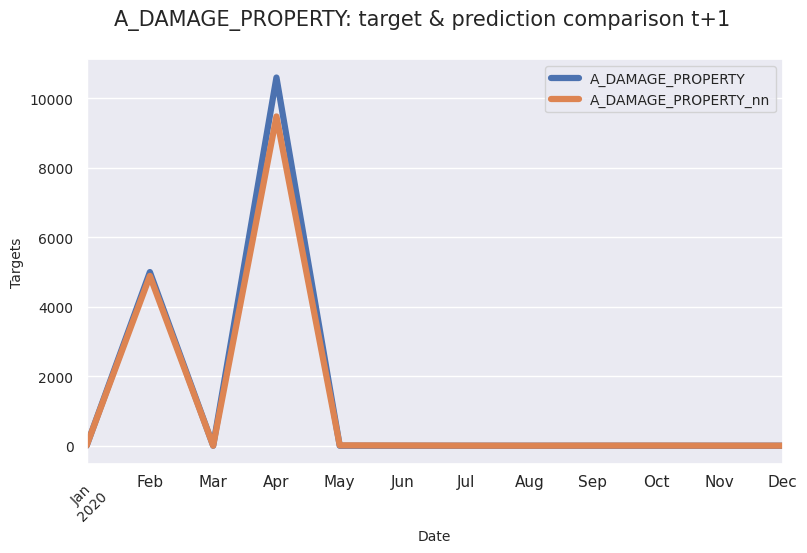

In [ ]:
# Plot results
test_df_nn_t_1=test_2020_sc.copy()
test_df_nn_t_1 = pd.concat([test_df_nn_t_1, predictions_te_nn_t_1.set_index(test_df_nn_t_1.index)], axis=1)
test_df_nn_t_1_agg = test_df_nn_t_1.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_nn': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_nn_t_1_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+1', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

#### Prediction step 2

In [ ]:
# create lag and window features on all dataset for t+1
test_df_pred_nn_t_1 = test_df_nn_t_1.copy()
test_df_pred_nn_t_1.drop(['A_DAMAGE_PROPERTY'], axis=1, inplace=True)
test_df_pred_nn_t_1.rename(columns={'A_DAMAGE_PROPERTY_nn': 'A_DAMAGE_PROPERTY'}, inplace=True)

# create lag and window features on all dataset for t+2
all_sc_t_2=pd.concat([train_sc,test_df_pred_nn_t_1,test_2021_sc],axis=0)
all_sc_lag_t_2=lag_feat(all_sc_t_2, 'A_DAMAGE_PROPERTY')
all_sc_win_lag_t_2=win_feat(all_sc_lag_t_2,'A_DAMAGE_PROPERTY')

# retrieve test set for t+2
test_sc_t_2 = all_sc_win_lag_t_2[(all_sc_win_lag_t_2.index >= '2021-01-01') & (all_sc_win_lag_t_2.index < '2022-01-01')]

# split features from target for t+2
X_test_sc_t_2 = test_sc_t_2.copy()
y_test_sc_t_2 = X_test_sc_t_2.A_DAMAGE_PROPERTY
y_test_sc_t_2 = pd.DataFrame(y_test_sc_t_2, columns=['A_DAMAGE_PROPERTY'])
X_test_sc_t_2.drop(['A_DAMAGE_PROPERTY','NBCLAIMS_DIRECT'], axis=1, inplace=True)
X_test_sc_t_2_ = pd.concat([X_test_sc_t_2, test_weights_sc_t_2_df], axis=1)



In [ ]:
# Prediction t+2
score_nn_t_2 = []
predictions_te_nn_t_2 = np.maximum(nn_tuned.predict(X_test_sc_t_2_), 1e-12)
rmse_test = np.sqrt(mean_squared_error(y_test_sc_t_2, predictions_te_nn_t_2))
mae_test = mean_absolute_error(y_test_sc_t_2, predictions_te_nn_t_2)
mgd_test = mean_gamma_deviance(np.maximum(y_test_sc_t_2,1e-12), predictions_te_nn_t_2)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test
    }

score_nn_t_2.append(score_dict)
score_nn_t_2 = pd.DataFrame(score_nn_t_2, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_te_nn_t_2 = pd.DataFrame(predictions_te_nn_t_2, columns = ['A_DAMAGE_PROPERTY_nn'])


#### Evaluation step 2

In [ ]:
nn_results_t_2 = {'step':['t+2'],
                'model':['nn'],
               'rmse_train':score_nn_t_2['rmse_train'],
               'rmse_test': score_nn_t_2['rmse_test'],
              'mae_train': score_nn_t_2['mae_train'],
              'mae_test': score_nn_t_2['mae_test'],
               'mgd_train': score_nn_t_2['mgd_train'],
               'mgd_test': score_nn_t_2['mgd_test']
               }
score_nn_t_2 = pd.DataFrame(nn_results_t_2,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_nn_t_2

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+2,nn,493.470887,422.186881,34.395967,22.13213,21.922529,9.382404


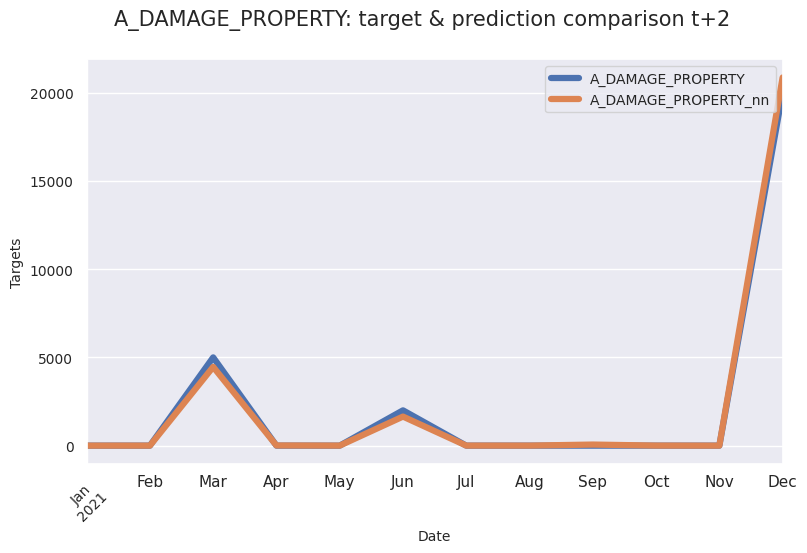

In [ ]:
# Plot results
test_df_nn_t_2=test_2021_sc.copy()
test_df_nn_t_2 = pd.concat([test_df_nn_t_2, predictions_te_nn_t_2.set_index(test_df_nn_t_2.index)], axis=1)
test_df_nn_t_2_agg = test_df_nn_t_2.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_nn': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_nn_t_2_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+2', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

#### Prediction step 3

In [ ]:
# create lag and window features on all dataset for t+3
test_df_pred_nn_t_2 = test_df_nn_t_2.copy()
test_df_pred_nn_t_2.drop(['A_DAMAGE_PROPERTY'], axis=1, inplace=True)
test_df_pred_nn_t_2.rename(columns={'A_DAMAGE_PROPERTY_nn': 'A_DAMAGE_PROPERTY'}, inplace=True)

# create lag and window features on all dataset for t+3
all_sc_t_3=pd.concat([train_sc,test_df_pred_nn_t_1,test_df_pred_nn_t_2,test_2022_sc],axis=0)
all_sc_lag_t_3=lag_feat(all_sc_t_3, 'A_DAMAGE_PROPERTY')
all_sc_win_lag_t_3=win_feat(all_sc_lag_t_3,'A_DAMAGE_PROPERTY')

# retrieve test set for t+3
test_sc_t_3 = all_sc_win_lag_t_3[(all_sc_win_lag_t_3.index >= '2022-01-01') & (all_sc_win_lag_t_3.index < '2023-01-01')]

# split features from target for t+3
X_test_sc_t_3 = test_sc_t_3.copy()
y_test_sc_t_3 = X_test_sc_t_3.A_DAMAGE_PROPERTY
y_test_sc_t_3 = pd.DataFrame(y_test_sc_t_3, columns=['A_DAMAGE_PROPERTY'])
X_test_sc_t_3.drop(['A_DAMAGE_PROPERTY','NBCLAIMS_DIRECT'], axis=1, inplace=True)
X_test_sc_t_3_ = pd.concat([X_test_sc_t_3, test_weights_t_3_df], axis=1)



In [ ]:
# prediction t+3
score_nn_t_3 = []
predictions_te_nn_t_3 = np.maximum(nn_tuned.predict(X_test_sc_t_3_), 1e-12)
rmse_test = np.sqrt(mean_squared_error(y_test_sc_t_3, predictions_te_nn_t_3))
mae_test = mean_absolute_error(y_test_sc_t_3, predictions_te_nn_t_3)
mgd_test = mean_gamma_deviance(np.maximum(y_test_sc_t_3,1e-12), predictions_te_nn_t_3)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test
    }

score_nn_t_3.append(score_dict)
score_nn_t_3 = pd.DataFrame(score_nn_t_3, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
predictions_te_nn_t_3 = pd.DataFrame(predictions_te_nn_t_3, columns = ['A_DAMAGE_PROPERTY_nn'])


#### Evaluation step 3

In [ ]:
nn_results_t_3 = {'step':['t+3'],
                'model':['nn'],
               'rmse_train':score_nn_t_3['rmse_train'],
               'rmse_test': score_nn_t_3['rmse_test'],
              'mae_train': score_nn_t_3['mae_train'],
              'mae_test': score_nn_t_3['mae_test'],
               'mgd_train': score_nn_t_3['mgd_train'],
               'mgd_test': score_nn_t_3['mgd_test']
               }
score_nn_t_3 = pd.DataFrame(nn_results_t_3,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mgd_train','mgd_test'])
score_nn_t_3

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+3,nn,493.470887,205.633831,34.395967,9.091482,21.922529,11.248072


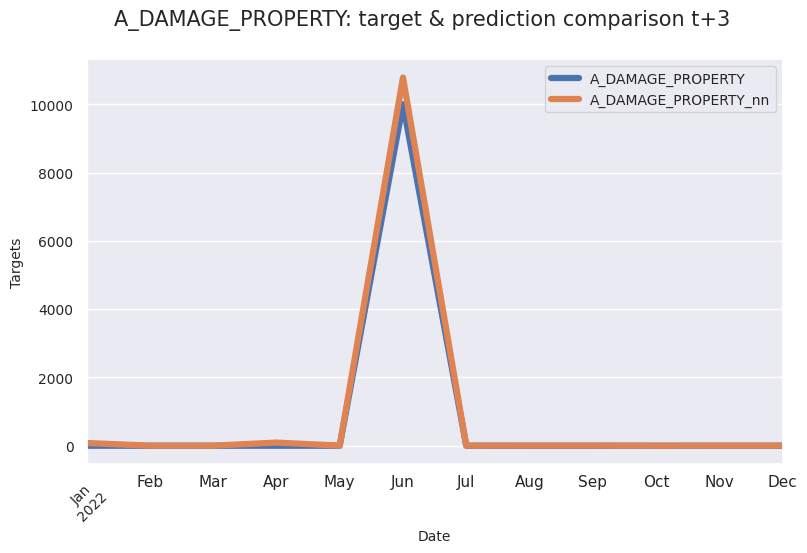

In [ ]:
# Plot results
test_df_nn_t_3=test_2022_sc.copy()
test_df_nn_t_3 = pd.concat([test_df_nn_t_3, predictions_te_nn_t_3.set_index(test_df_nn_t_3.index)], axis=1)
test_df_nn_t_3_agg = test_df_nn_t_3.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_nn': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_nn_t_3_agg.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY: target & prediction comparison t+3', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

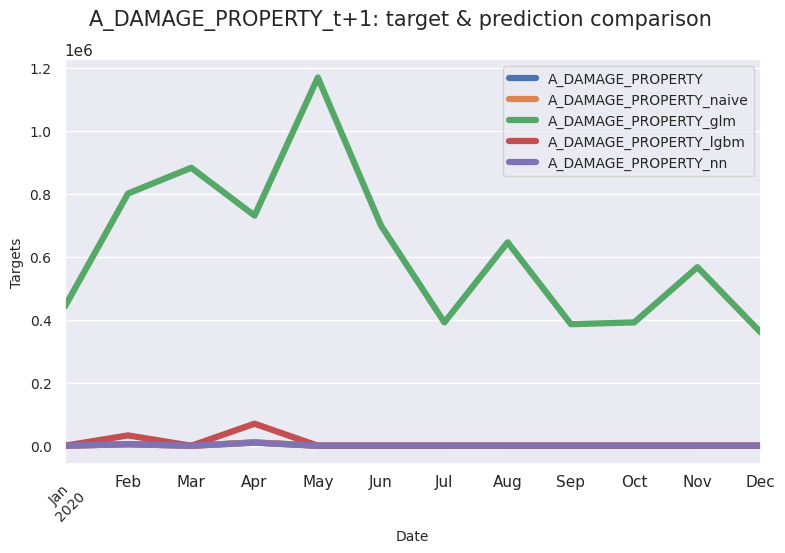

In [ ]:
# plot all models t+1
test_df_t_1 = pd.concat([test_t_1['A_DAMAGE_PROPERTY'], predictions_te_naive_t_1.set_index(test_t_1.index),
                     predictions_te_glm_t_1.set_index(test_t_1.index),predictions_te_lgbm_t_1.set_index(test_t_1.index),
                     predictions_te_nn_t_1.set_index(test_t_1.index)], axis=1)
test_df_agg_t_1 = test_df_t_1.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_naive': 'sum',
    'A_DAMAGE_PROPERTY_glm': 'sum',
    'A_DAMAGE_PROPERTY_lgbm': 'sum',
    'A_DAMAGE_PROPERTY_nn': 'sum'
    })
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg_t_1.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY_t+1: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

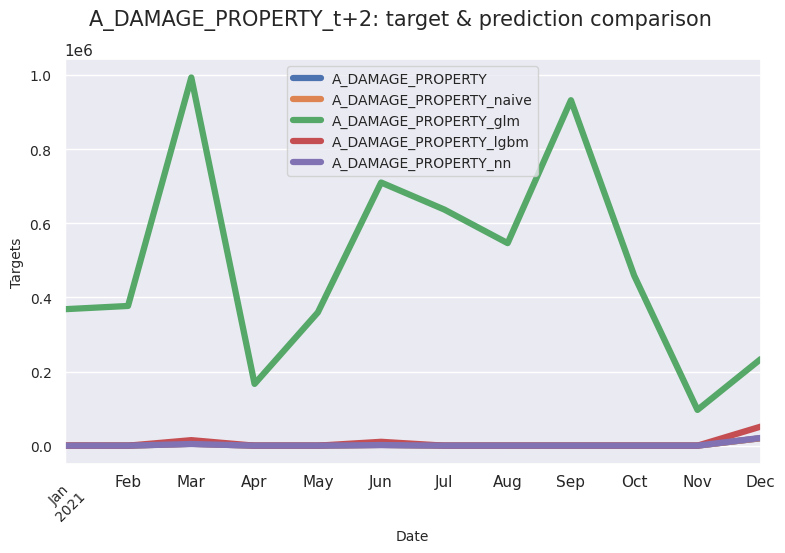

In [ ]:
# plot all models t+2
test_df_t_2 = pd.concat([test_t_2['A_DAMAGE_PROPERTY'], predictions_te_naive_t_2.set_index(test_t_2.index),
                     predictions_te_glm_t_2.set_index(test_t_2.index),predictions_te_lgbm_t_2.set_index(test_t_2.index),
                     predictions_te_nn_t_2.set_index(test_t_2.index)], axis=1)
test_df_agg_t_2 = test_df_t_2.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_naive': 'sum',
    'A_DAMAGE_PROPERTY_glm': 'sum',
    'A_DAMAGE_PROPERTY_lgbm': 'sum',
    'A_DAMAGE_PROPERTY_nn': 'sum'
    })
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg_t_2.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY_t+2: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

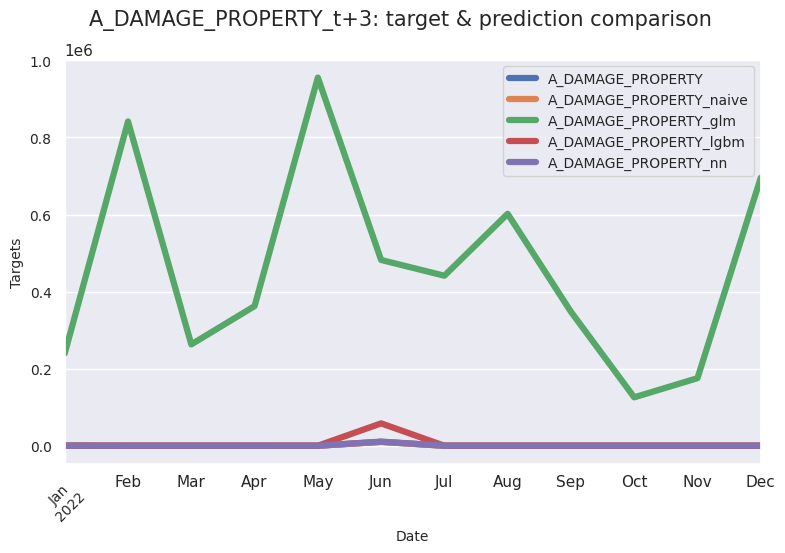

In [ ]:
# plot all models t+3
test_df_t_3 = pd.concat([test_t_3['A_DAMAGE_PROPERTY'], predictions_te_naive_t_3.set_index(test_t_3.index),
                     predictions_te_glm_t_3.set_index(test_t_3.index),predictions_te_lgbm_t_3.set_index(test_t_3.index),
                     predictions_te_nn_t_3.set_index(test_t_3.index)], axis=1)
test_df_agg_t_3 = test_df_t_3.groupby(pd.Grouper(freq='M')).agg({
    'A_DAMAGE_PROPERTY': 'sum',
    'A_DAMAGE_PROPERTY_naive': 'sum',
    'A_DAMAGE_PROPERTY_glm': 'sum',
    'A_DAMAGE_PROPERTY_lgbm': 'sum',
    'A_DAMAGE_PROPERTY_nn': 'sum'
    })
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg_t_3.plot(linewidth=4.5)
plt.suptitle('A_DAMAGE_PROPERTY_t+3: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

In [ ]:
def plot_metrics(score_df):
  # Reset the index of the DataFrame
  score_df = score_df.reset_index(drop=True)


  # Replace 'N/A' with 0 only for the 'naive' row
  score_df.loc[score_df['model'] == 'naive', ['mgd_train', 'mgd_test']] = score_df.loc[score_df['model'] == 'naive', ['mgd_train', 'mgd_test']].replace('N/A', 0)

  # Convert 'mpd_train' and 'mpd_test' to float type
  score_df['mgd_train'] = score_df['mgd_train'].astype(float)
  score_df['mgd_test'] = score_df['mgd_test'].astype(float)

  # Plotting 6 charts with 3 per row
  plt.figure(figsize=(18, 12))

  # Plot RMSE comparison for Train and Test
  plt.subplot(2, 3, 1)
  plt.bar(score_df['model'], score_df['rmse_train'], color='b', alpha=0.7, label='RMSE Train')
  plt.xlabel('Model',fontsize=15)
  plt.ylabel('RMSE')
  plt.xticks(fontsize=15)
  plt.legend()
  plt.title('RMSE Comparison - Train')

  plt.subplot(2, 3, 4)
  plt.bar(score_df['model'], score_df['rmse_test'], color='r', alpha=0.7, label='RMSE Test')
  plt.xlabel('Model')
  plt.ylabel('RMSE')
  plt.xticks(fontsize=15)
  plt.legend()
  plt.title('RMSE Comparison - Test')

  # Plot MAE comparison for Train and Test
  plt.subplot(2, 3, 2)
  plt.bar(score_df['model'], score_df['mae_train'], color='b', alpha=0.7, label='MAE Train')
  plt.xlabel('Model')
  plt.xticks(fontsize=15)
  plt.ylabel('MAE')
  plt.legend()
  plt.title('MAE Comparison - Train')

  plt.subplot(2, 3, 5)
  plt.bar(score_df['model'], score_df['mae_test'], color='r', alpha=0.7, label='MAE Test')
  plt.xlabel('Model')
  plt.ylabel('MAE')
  plt.xticks(fontsize=15)
  plt.legend()
  plt.title('MAE Comparison - Test')

  # Plot MPD comparison for Train and Test
  plt.subplot(2, 3, 3)
  plt.bar(score_df['model'], score_df['mgd_train'], color='b', alpha=0.7, label='MGD Train')
  plt.xlabel('Model')
  plt.ylabel('MGD')
  plt.xticks(fontsize=15)
  plt.legend()
  plt.title('MGD Comparison - Train')

  plt.subplot(2, 3, 6)
  plt.bar(score_df['model'], score_df['mgd_test'], color='r', alpha=0.7, label='MGD Test')
  plt.xlabel('Model')
  plt.ylabel('MGD')
  plt.xticks(fontsize=15)
  plt.legend()
  plt.title('MGD Comparison - Test')

  plt.tight_layout()
  plt.show()

In [ ]:
# total score
score_t_1 = pd.concat([score_naive_t_1, score_glm_t_1, score_lgbm_t_1, score_nn_t_1])
score_t_1

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+1,naive,778.966123,313.378417,43.983067,12.220917,N/A,N/A
0,t+1,glm,2951.800600,2924.297191,2931.789907,2923.069021,69.071048,69.142471
0,t+1,lgbm,1039.626672,516.423548,94.787978,34.125705,15.706429,15.346222
0,t+1,nn,493.470887,205.494152,34.395967,9.997392,21.922529,12.996231


In [ ]:
# total score
score_t_2 = pd.concat([score_naive_t_2, score_glm_t_2, score_lgbm_t_2, score_nn_t_2])
score_t_2

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+2,naive,778.966123,653.187114,43.983067,26.852312,N/A,N/A
0,t+2,glm,2951.800600,2944.982668,2931.789907,2927.629421,69.071048,69.123014
0,t+2,lgbm,1039.626672,523.980737,94.787978,40.005036,15.706429,15.381059
0,t+2,nn,493.470887,422.186881,34.395967,22.132130,21.922529,9.382404


In [ ]:
# total score
score_t_3 = pd.concat([score_naive_t_3, score_glm_t_3, score_lgbm_t_3, score_nn_t_3])
score_t_3

,step,model,rmse_train,rmse_test,mae_train,mae_test,mgd_train,mgd_test
0,t+3,naive,778.966123,325.128044,43.983067,10.570825,N/A,N/A
0,t+3,glm,2951.800600,2925.761505,2931.789907,2924.202618,69.071048,69.186786
0,t+3,lgbm,1039.626672,462.107608,94.787978,25.542506,15.706429,14.956231
0,t+3,nn,493.470887,205.633831,34.395967,9.091482,21.922529,11.248072


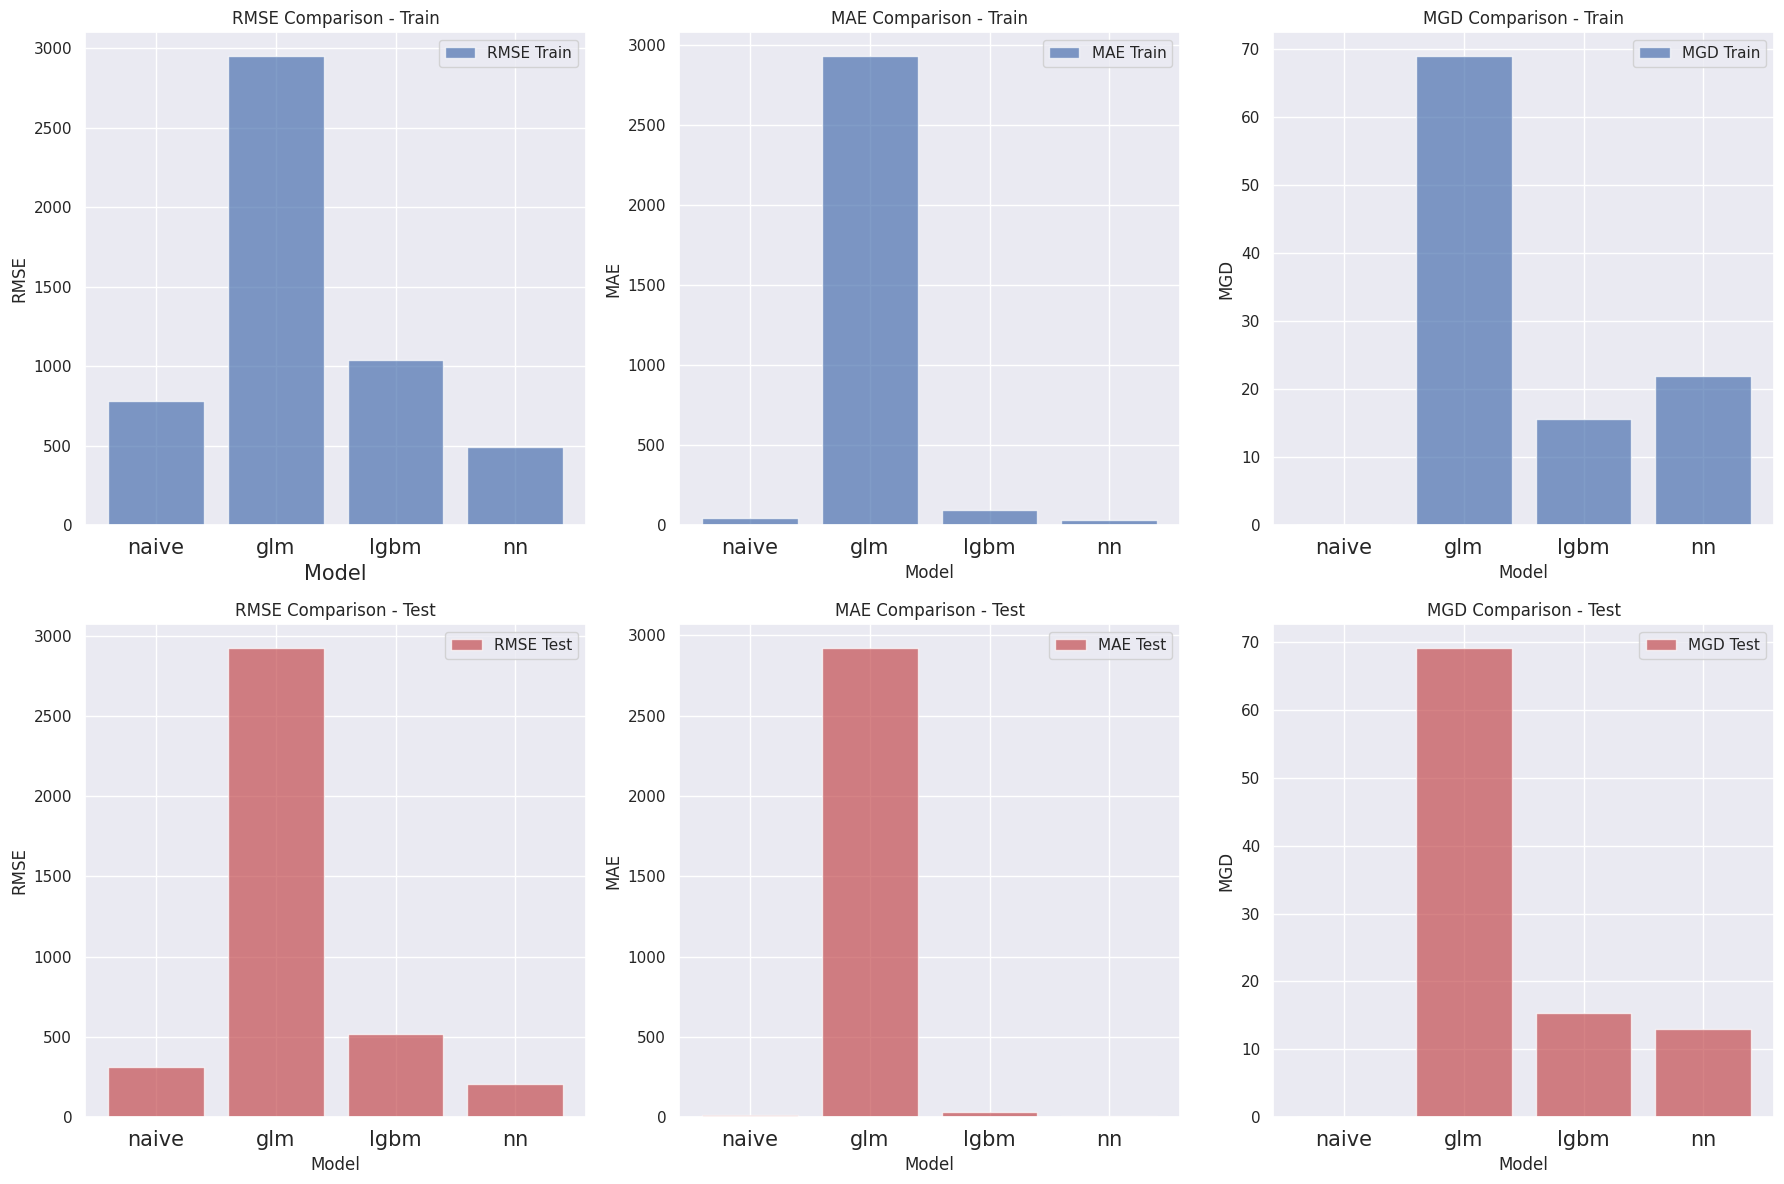

In [ ]:
plot_metrics(score_t_1)

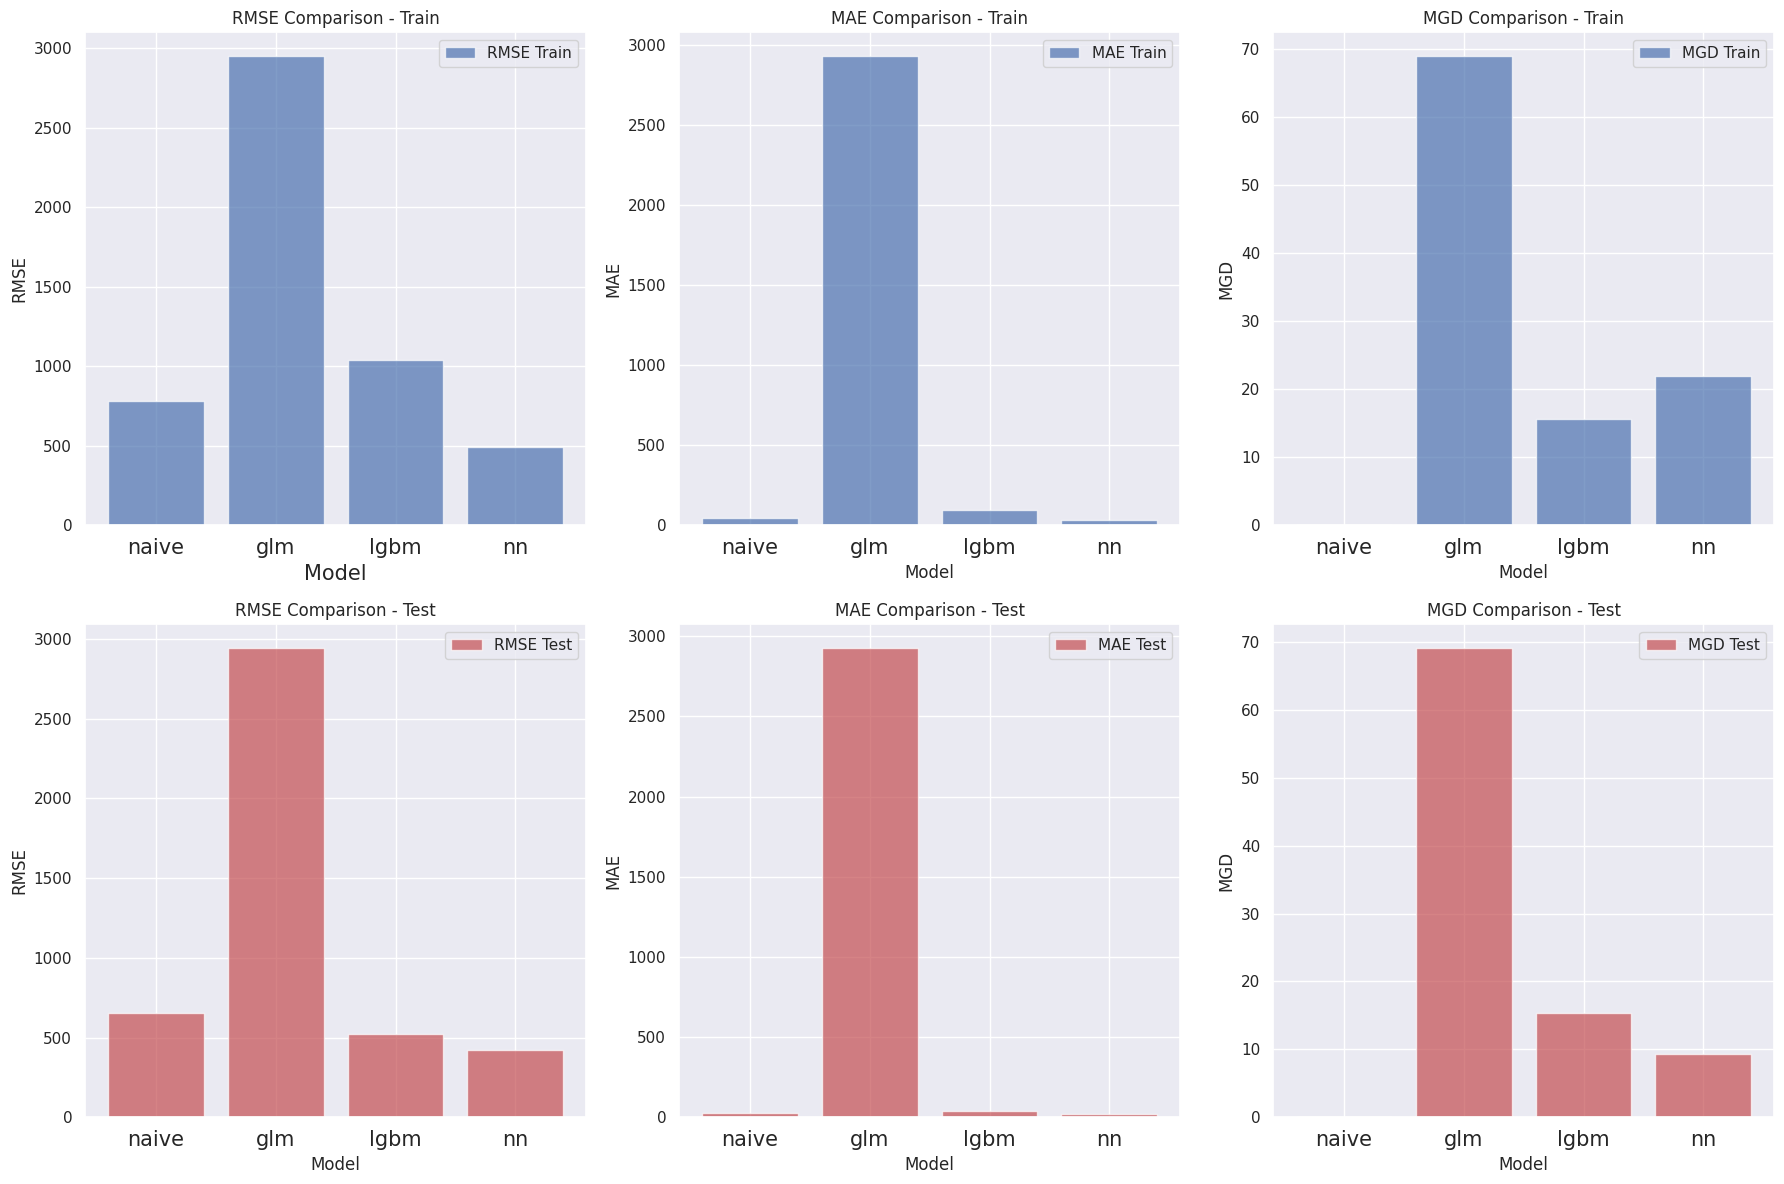

In [ ]:
plot_metrics(score_t_2)

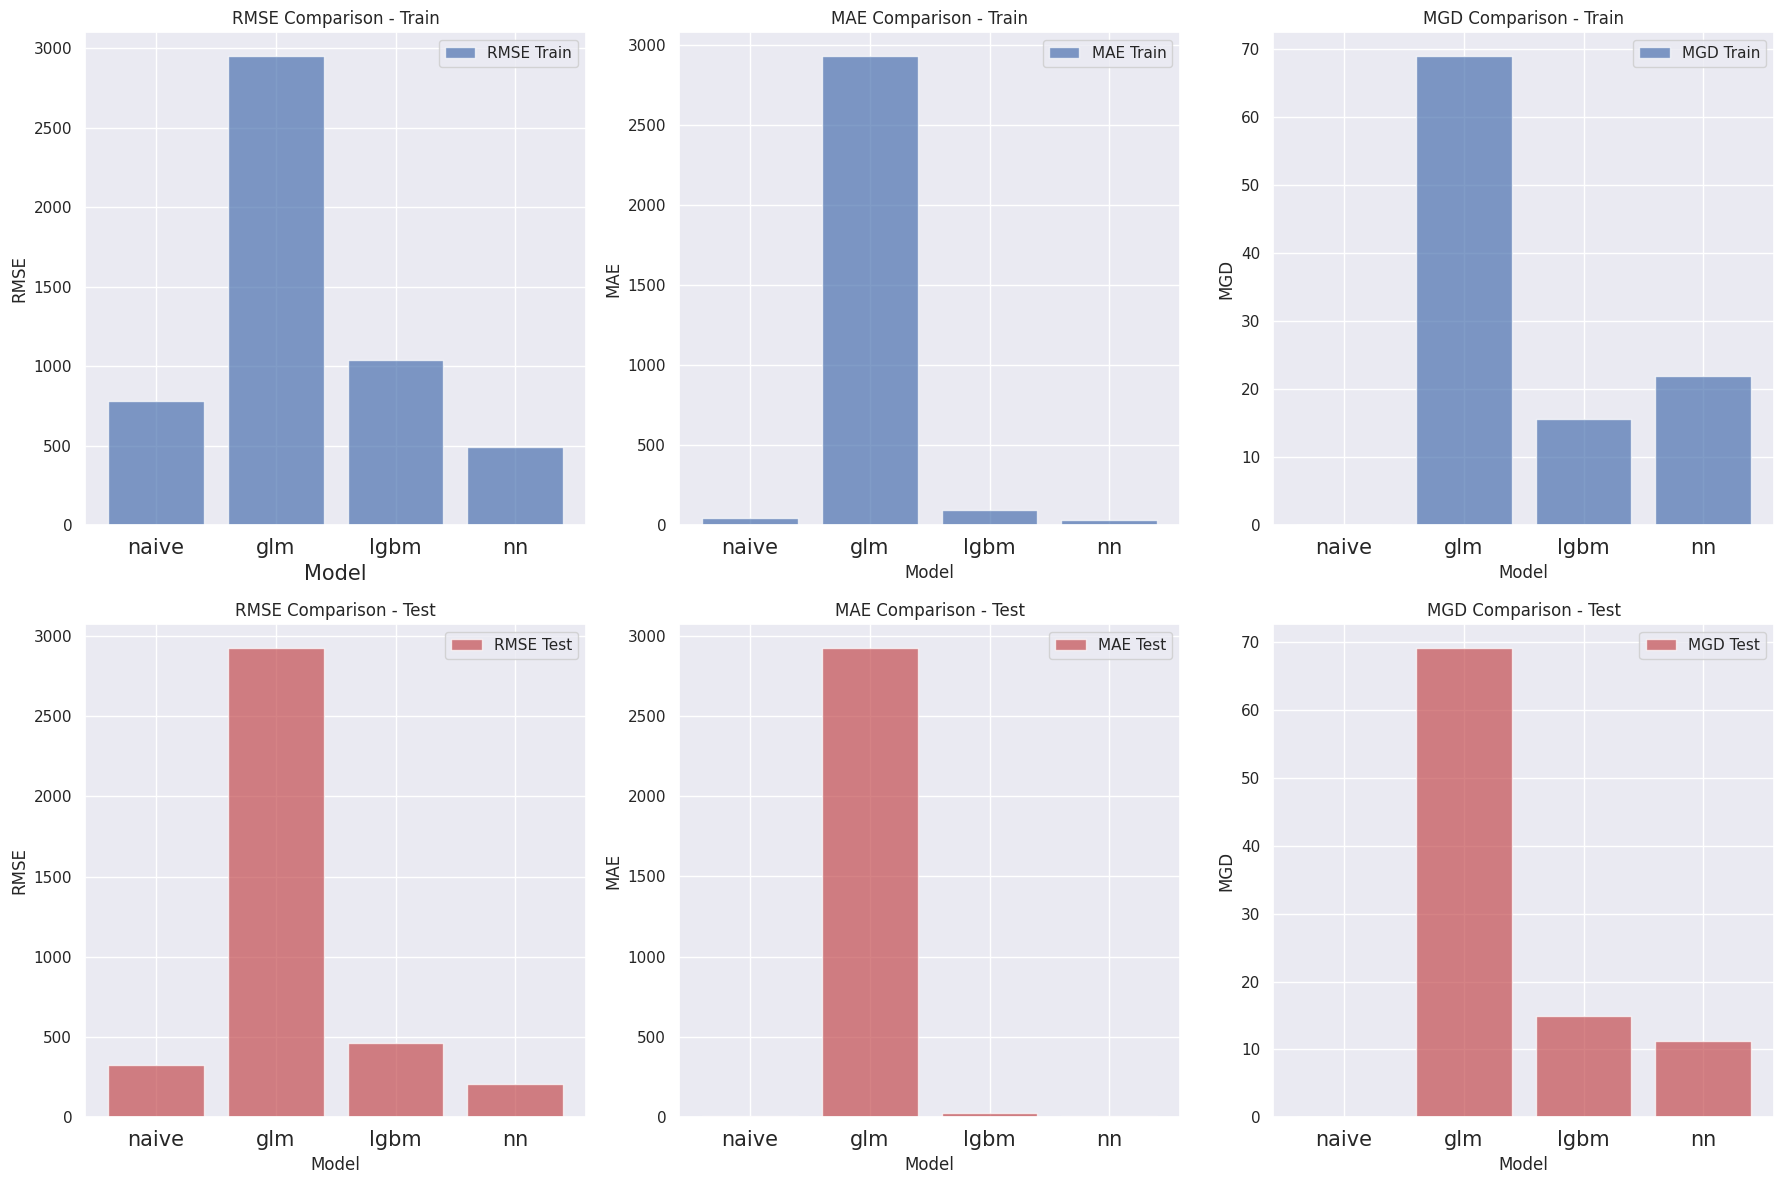

In [ ]:
plot_metrics(score_t_3)